In [ ]:
# default_exp

# Full Example

> Exhibiting the tools contained in this library using data from a collider phenomenology study of $Z'$ particles

In [ ]:
# hide
from nbdev.showdoc import *

## Preparing Data

Informed by the documentation of the `import47Ddata` function, we can pull in all of the data files we'll need for training and testing from Google Storage. These were previously produced by printing out kinematic information from `.lhe` files generated by [MadGraph](http://madgraph.phys.ucl.ac.be/index.html) using a [MadAnalysis](https://madanalysis.irmp.ucl.ac.be/) expert mode script.

In [ ]:
filename_sig_masses = ['350G', '500G', '1T', '2T', '4T']
filename_bgs = ['h', '4t', 'noh']

In [ ]:
signal_data = [import47Ddata(f'sig{mass}') for mass in filename_sig_masses]

In [ ]:
background_data = [import47Ddata(f'bg{name}') for name in filename_bgs]

Now, using `sklearn.model_selection.train_test_split` we can split our data sets--one for each $m_{Z'}$ value--into training and testing subsets and create labels for each of these. 

In [ ]:
from sklearn.model_selection import train_test_split
data = []
for sig_data in signal_data:
    train_preds, test_preds, train_binary_labels, test_binary_labels, train_labels, test_labels = train_test_split(
        np.concatenate([sig_data] + [bg_data[:int(len(sig_data)/3)] for bg_data in background_data]),
        [1] * len(sig_data) + [0] * 3 * int(len(sig_data)/3),
        [1] * len(sig_data) + [-1] * int(len(sig_data)/3) + [-2] * int(len(sig_data)/3) + [-3] * int(len(sig_data)/3),
        test_size=0.25, random_state=42) 
    data.append([[train_preds, train_binary_labels, train_labels],
                 [test_preds, test_binary_labels, test_labels]])
del train_preds, test_preds, train_binary_labels, test_binary_labels, train_labels, test_labels

Here, we have created a list `data` of length $5$ (as we have $5$ sampled $Z'$ masses) where each row contains two lists, each of which contains three `numpy` arrays. The first triplet is the $n \times m$ data set of training predictors (where $n$ is the number of data points and $m$ is the number of features: for us, $n \approx 2$ million and $m = 47$), the length $n$ binary labels (i.e., signal is $1$, background is $0$) to be used for training, and the length $n$ labels (i.e., signal is $1$, background is negative integer) to be used when we want to differentiate backgrounds. Thus, our list is $5 \times 2 \times 3$, where the final dimension consists of predictors and labels as described above. We note that, in particular, we constructed our training/testing data for each $m_{Z'}$ value by combining $1$ million signal data points with ~$1$ million background points (divided evenly between our three background types).

In [ ]:
print(f'data has length {len(data)}')
print(f'each row of data has length {len(data[0])}')
print(f'each element in each row of data has length {len(data[0][0])}')
print(f'training data is of length {len(data[0][0][0])}',
      f'while testing data is of length {len(data[0][1][0])}')
print(f'our data has {len(data[0][0][0][0])} features')

data has length 5
each row of data has length 2
each element in each row of data has length 3
training data is of length 1499999 while testing data is of length 500000
our data has 47 features


We're also going to want one more thing. In particular, we'll eventually want to pass the (test) predictors and labels that correspond to specific background types. In order to facilitate this, we're going to construct a list `indx` of length $5$ (number of $Z'$ masses) where each row is a list of length $4$ (as we have signal and three background types) where `data[i][j]` is a `numpy` array containing the indices of `test[i][1][2]` corresponding to signal (if $j = 0$) or the $j$th background (if $1 \leq j \leq 3$).

In [ ]:
indx = [[np.where(row[1][2]==i)[0] for i in [1] + [-i for i in range(1,4)]] for row in data]

In [ ]:
print(f'indx has length {len(indx)}')
print(f'each row of indx has length {len(indx[0])}')
print(f'the lengths of the elements of the first row of indx are {[len(elem) for elem in indx[0]]}')

indx has length 5
each row of indx has length 4
the lengths of the elements of the first row of indx are [249991, 83394, 83544, 83071]


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

It's useful for standardize your data (subtract the mean and divide by the standard deviation in each feature) before training: we can achieve this through `sklearn`'s `StandardScaler` filter and its `pipeline` functionality.

### Initializing and Training

We'll now initialize and train a logistic regression model for each of our $5$ data sets using our `bcml_model` object. Note that the `*` syntax unpacks a list, so our training data and testing data for a given $Z'$ mass (which makes up our rows of `train_test_data`) are passed as separate arguments to our class instantiation. 

We instantiate a `bcml_model` object by passing a `sklearn` classifying model and we fit the model via the `bcml.fit` method.

In [ ]:
logreg_m350G_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m350G_model.fit(*data[0][0][:2])

In [ ]:
logreg_m500G_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m500G_model.fit(*data[1][0][:2])

In [ ]:
logreg_m1T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m1T_model.fit(*data[2][0][:2])

In [ ]:
logreg_m2T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m2T_model.fit(*data[3][0][:2])

In [ ]:
# this one takes a little longer to converge, we'll bump up max_iter from 100 to 500
logreg_m4T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression(max_iter=500)))
logreg_m4T_model.fit(*data[4][0][:2])

As a reminder, passing `*data[0][0][:2]`, for example, means we are taking the zeroth row of `data` (first mass, $m_{Z'} = 350$ GeV), the zeroth element of that row (the training data, not the testing data), and then unpacking the first two elements of that element (the features and binary labels).

### Naive Performance Evaluation

Now we can investigate our models' performances. Perhaps we can start by looking at the signal significance they achieve by default, given integrated luminosity $\mathcal{L} = 3000$ fb$^{-1}$. To do this, we're going to need signal and background yield, which we can compute using the function `get_elijah_ttbarzp_cs`, which can pull in our information regarding sampled $Z'$ masses, their associated cross sections, and the background cross sections.

In [ ]:
masses, sig_css, bg_css = get_elijah_ttbarzp_cs()
print(masses)

[10, 50, 100, 200, 350, 500, 1000, 2000, 5000]


We will need a signal cross section for $m_{Z'} = 4000$ GeV, which we don't have, so we shall take a quick detour to interpolate it using our `cross_section_helper` object. In doing so, we'll update `masses` and `sig_css` to more relevant values.

In [ ]:
zp_cs = cross_section_helper(masses, sig_css, bg_css, mass_units='GeV')
masses = [350, 500, 1000, 2000, 4000]
sig_css = [zp_cs.sig_cs(mass) for mass in masses]

Using $N = \mathcal{L} \cdot \sigma$ for number of events $N$, we can compute signal and background yields. Both of these are lists: signal cross sections vary with the $m_{Z'}$ values given by our `masses` variable, and the background cross sections vary between background types, originally specified by the `filename_bgs` variable.

In [ ]:
conv = 10**15 / 10**12 # conv * lumi (in fb^{-1}) * cross sec (in pb) = # of events
lumi = 3000
signal_yields = [conv * lumi * sig_cs for sig_cs in sig_css]
background_yields = [conv * lumi * bg_cs for bg_cs in bg_css]
background_yield = sum(background_yields)

Now we can look at anticipated signal significance $\mathcal{S}$ yielded by our models, which takes the following form.
$$\mathcal{S} = \frac{S \cdot \text{TPR}}{\sqrt{S \cdot \text{TPR} + B \cdot \text{FPR}}}$$
Here, $S$ and $B$ are signal and background yield, respectively; TPR is the true positive rate, or the proportion of signal events our model correctly identifies as signal; and FPR is the false positive rate, or the proportion of background events our model incorrectly identifies as signal (i.e., TPR, FPR $\in [0, 1]$). Effectively, we're implementing a solitary event selection criterion: namely, that our model thinks the event is signal.

However, I first want to introduce a subtlety. We have thus lumped our backgrounds together and placed them on equal footing: in particular, we implemented equal amounts of each background in our training/testing data, and labelled them all the same. However, in reality, our backgrounds are decidedly not the same: in our case, let's see how the cross sections compare.

In [ ]:
for B, name in zip(background_yields, filename_bgs):
    print(f"Background {name} constitutes {round(B/background_yield,3)}% of the total background cross section.")

Background h constitutes 0.019% of the total background cross section.
Background 4t constitutes 0.002% of the total background cross section.
Background noh constitutes 0.979% of the total background cross section.


The `noh` (no Higgs) background is far and away the dominant process. It seems negligent, then, to compute total FPR and multiply by total B (background yield): instead, we should be multiplying the FPR for each background by the associated background yield B, and then summing over these. The `bcml_model.significance` method allows us to specify whether or not we want to separate our backgrounds like this in the computation with the boolean argument `sepbg`. Let's look at both scenarios.

We'll import `datetime` to help ourselves start gauging runtime for some of these computational tasks.

In [ ]:
from datetime import datetime

def getTime(form='s'):
    seconds = datetime.now().day * 86400 + datetime.now().hour * 3600 + datetime.now().minute * 60 + datetime.now().second
    if form == 's':
        return seconds
    elif form == 'm':
        return round(seconds/60,3)
    elif form == 'h':
        return round(seconds/3600,3)

In [ ]:
time_before = getTime()
logreg_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(data[i][1][1], preds=data[i][1][0]), 
                                          fpr=model.fpr(data[i][1][1], preds=data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(logreg_models, signal_yields))]
for sig, mass in zip(logreg_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> logistic regression gives significance of 16.01 sigma w/o separated backgrounds
Z' mass = 500 GeV --> logistic regression gives significance of 8.386 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> logistic regression gives significance of 2.049 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> logistic regression gives significance of 0.283 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> logistic regression gives significance of 0.006 sigma w/o separated backgrounds
(Runtime: 33 seconds)


In [ ]:
time_before = getTime()
logreg_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(np.ones((len(indx[i][0]),)), preds=data[i][1][0][indx[i][0]]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True)
                       for i, (model, signal_yield) in enumerate(zip(logreg_models, signal_yields))]
for sig, mass in zip(logreg_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> logistic regression gives significance of 19.856 sigma w/ separated backgrounds
Z' mass = 500 GeV --> logistic regression gives significance of 9.527 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> logistic regression gives significance of 2.052 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> logistic regression gives significance of 0.263 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> logistic regression gives significance of 0.006 sigma w/ separated backgrounds
(Runtime: 14 seconds)


Numbers have limited utility on their own: let's try and visualize $\mathcal{S}$ as a function of $m_{Z'}$ with help from the interpolation functionality of `scipy` and some `matplotlib.pyplot` settings retrievable via `get_settings`.

In [ ]:
sample_masses = np.linspace(masses[0], masses[-1], 500)
max_mass = zp_cs.absolute_max_mass_sens()
logreg_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(logreg_sigs_nosepbg), kind='cubic')
logreg_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(logreg_sigs_sepbg), kind='cubic')

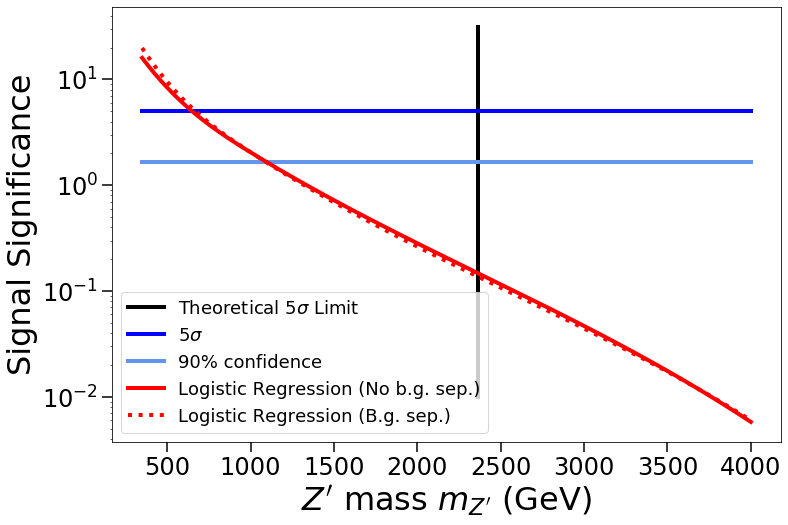

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 1.5, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**logreg_sigs_nosepbg_f(m) for m in sample_masses], label='Logistic Regression (No b.g. sep.)', 
        c='red')
    plt.plot(
        sample_masses, [10**logreg_sigs_sepbg_f(m) for m in sample_masses], label='Logistic Regression (B.g. sep.)', 
        c='red', linestyle=':')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

Whenever a curve falls above, say, the darker blue $5\sigma$ line, we are assured that the associated model can achieve $5\sigma$ discovery potential at that value of $m_{Z'}$. The "Theoretical 5$\sigma$ Limit" line denotes the highest $Z'$ mass such that $\mathcal{S} = 5\sigma$ is possible. In particular, in the best case scenario, TPR = 1 and FPR = 0, we have that $\mathcal{S} = \sqrt{S}$ so we require $\mathcal{L} \cdot \sigma_s > \mathcal{S}^2$ for signal cross section $\sigma_s$. Our `cross_section_helper` class has a built-in method for computing this maximal mass, given signal cross sections.

### More Sophisticated Evaluation: Threshold Optimization

When passed a data point, a trained `bcml_model` assigns a signal probability. By default, an `sk-learn` (and thus, our `bcml_model`) model predicts that the datapoint is signal if the associated signal probability is greater than $0.5$. However, $0.5$ need not be the optimal threshold: for this purpose, we provide the ability to optimize this threshold on a test data set. To visualize this, we can plot a histogram of predicted signal probability for signal and background test events in our model: this is easily achieved using the `bcml_model.predict_hist` method.

In [ ]:
logreg_models = [logreg_m350G_model, logreg_m500G_model, logreg_m1T_model, logreg_m2T_model, logreg_m4T_model]

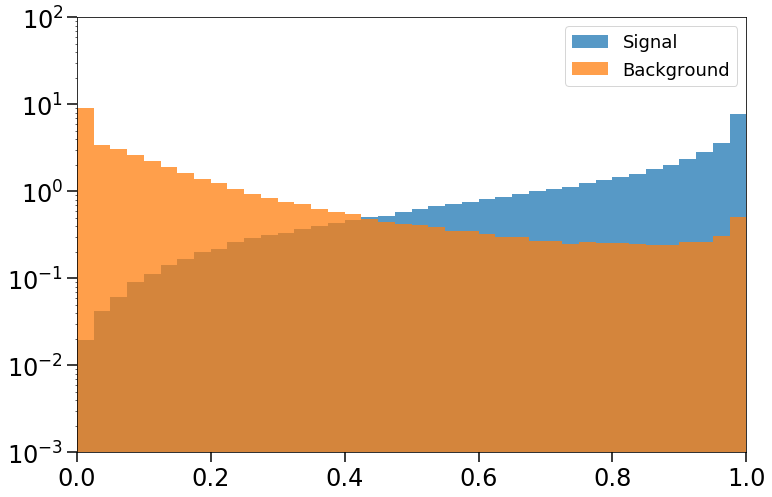

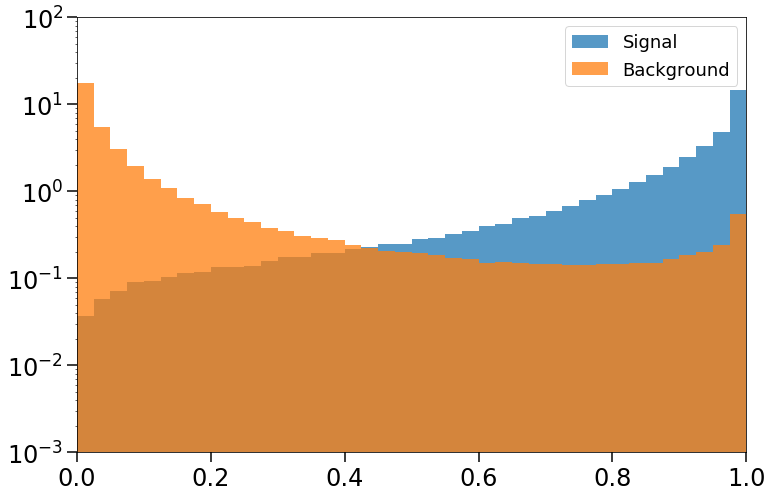

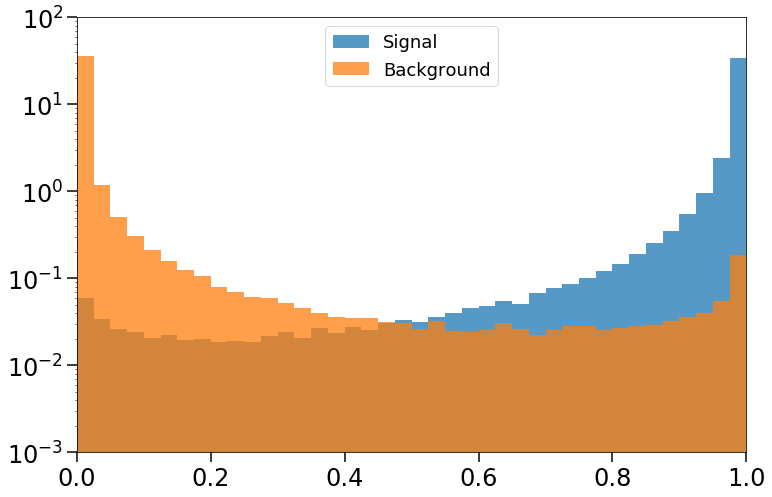

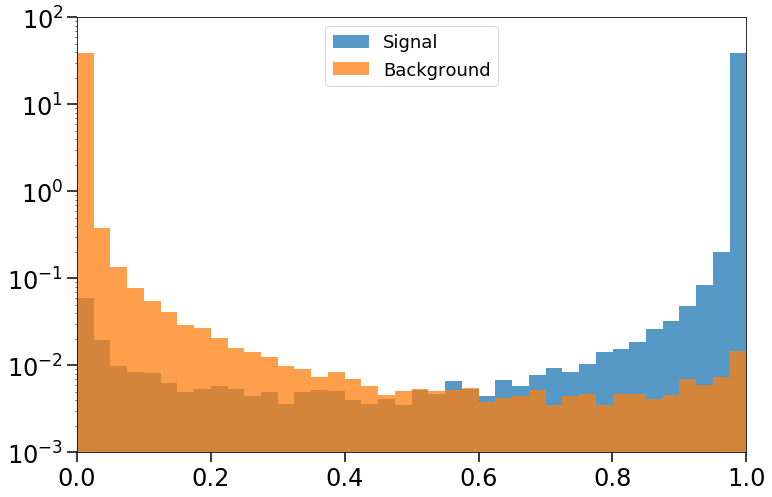

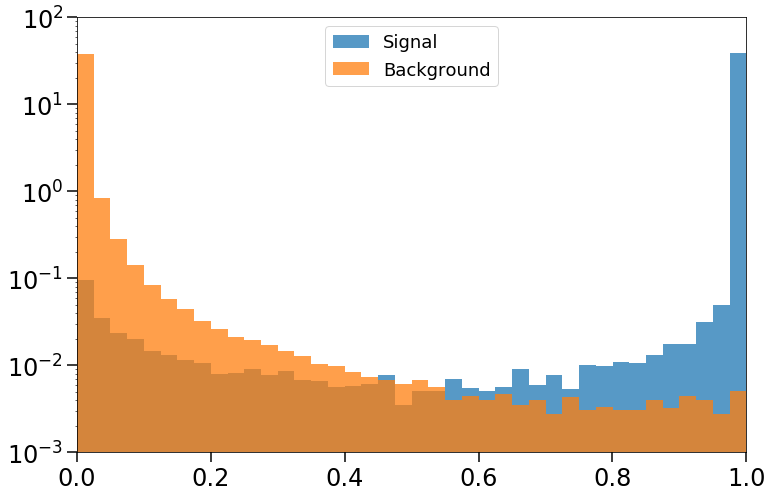

In [ ]:
background_names = ['Higgs', '4 Tops', 'No Higgs']
with plt.rc_context(get_settings()):
    for i, model in enumerate(logreg_models):
        plt.figure(i)
        bin_edges, sig_bins, bg_bins = model.predict_hist(data[i][1][0], data[i][1][1], num_bins=40, sepbg=False)
        plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", label="Signal")
        plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", label="Background")
        plt.yscale('log')
        plt.gca().set_ylim(10**-3, 10**2)
        plt.gca().set_xlim(0, 1)
        plt.legend()

Having motivated this endeavor, let's see how threshold optimization boosts our logistic regression models' performance: the `bcml_model.best_threshold` method performs this optimization task for us.

In [ ]:
time_before = getTime(form='m')
logreg_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, data[i][1][0], data[i][1][1],
                                                   sepbg=False) 
                              for i, (model, signal_yield) in enumerate(zip(logreg_models, signal_yields))]
logreg_opt_sigs_nosepbg = [result[1] for result in logreg_opt_results_nosepbg]
for sig, mass in zip(logreg_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> logistic regression gives optimized sign. of 17.545 sigma w/o separated backgrounds
Z' mass = 500 GeV --> logistic regression gives optimized sign. of 10.155 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> logistic regression gives optimized sign. of 3.588 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> logistic regression gives optimized sign. of 2.363 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> logistic regression gives optimized sign. of 1.01 sigma w/o separated backgrounds
(Runtime: 5.065999999998894 minutes)


In [ ]:
time_before = getTime(form='m')
logreg_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, data[i][1][0], data[i][1][2],
                                                   sepbg=True)
                              for i, (model, signal_yield) in enumerate(zip(logreg_models, signal_yields))]
logreg_opt_sigs_sepbg = [result[1] for result in logreg_opt_results_sepbg]
for sig, mass in zip(logreg_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> logistic regression gives optimized sign. of 22.274 sigma w/ separated backgrounds
Z' mass = 500 GeV --> logistic regression gives optimized sign. of 11.603 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> logistic regression gives optimized sign. of 3.519 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> logistic regression gives optimized sign. of 3.367 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> logistic regression gives optimized sign. of 1.01 sigma w/ separated backgrounds
(Runtime: 5.2 minutes)


Now we can overlay our new optimized signal significances onto our old plot to visualize (marked) improvement.

In [ ]:
logreg_opt_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(logreg_opt_sigs_nosepbg), kind='linear')
logreg_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(logreg_opt_sigs_sepbg), kind='linear')

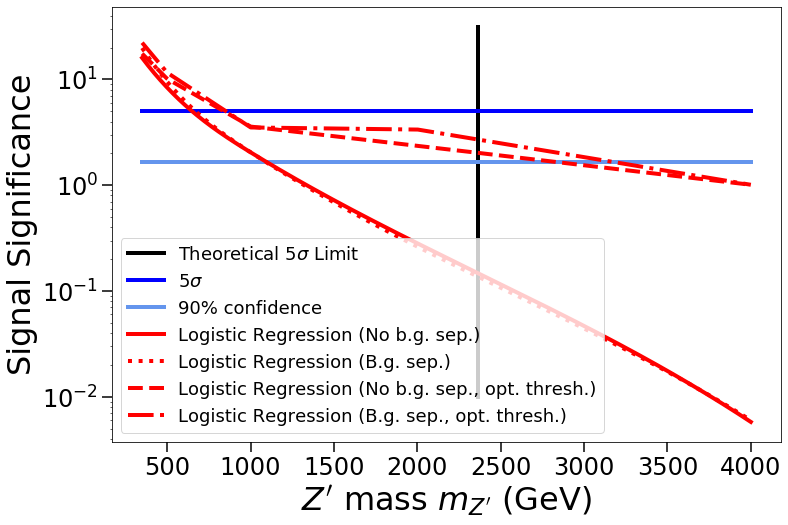

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 1.5, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**logreg_sigs_nosepbg_f(m) for m in sample_masses], label='Logistic Regression (No b.g. sep.)', 
        c='red')
    plt.plot(
        sample_masses, [10**logreg_sigs_sepbg_f(m) for m in sample_masses], label='Logistic Regression (B.g. sep.)', 
        c='red', linestyle=':')
    plt.plot(
        sample_masses, [10**logreg_opt_sigs_nosepbg_f(m) for m in sample_masses], 
        label='Logistic Regression (No b.g. sep., opt. thresh.)', 
        c='red', linestyle='--')
    plt.plot(
        sample_masses, [10**logreg_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Logistic Regression (B.g. sep., opt. thresh.)', 
        c='red', linestyle='-.')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

Additionally, we can re-plot our histogram with vertical lines visualizing where we used to be cutting for signal selection versus the optimal location (as our threshold determines the predicted signal probability required for a data point to be kept).

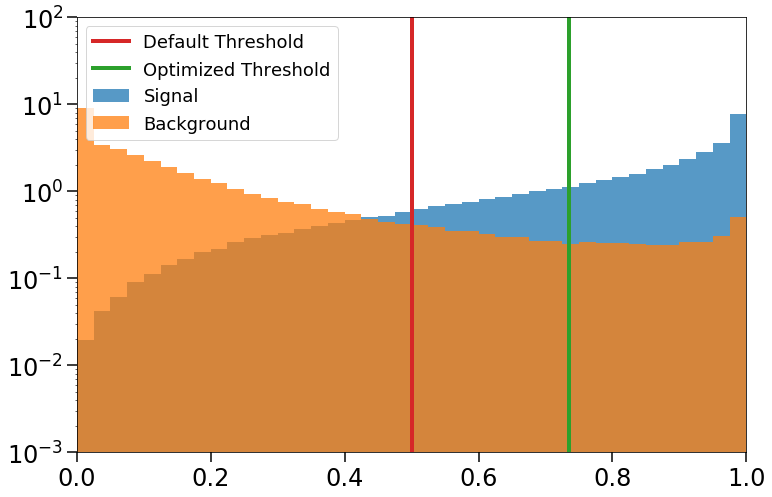

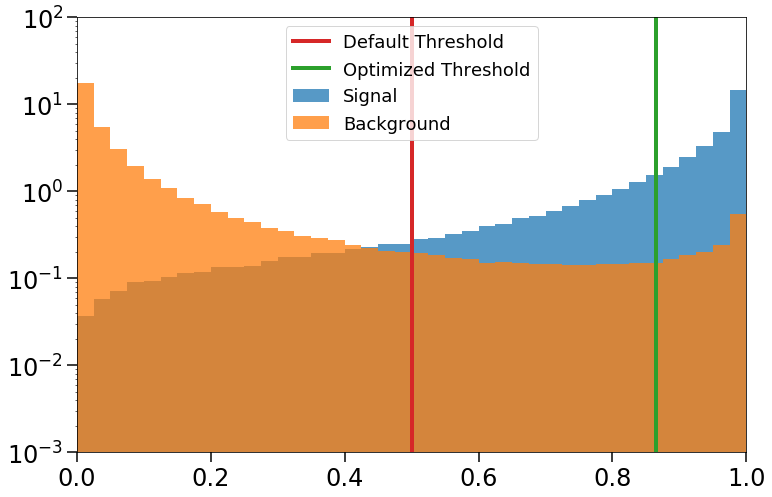

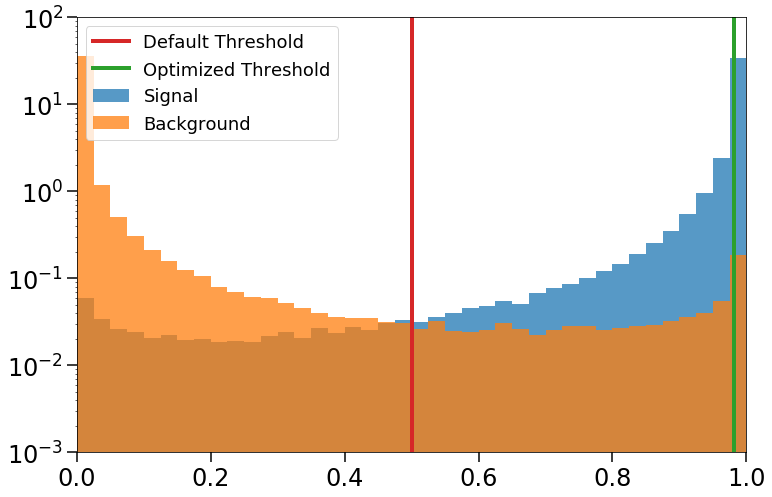

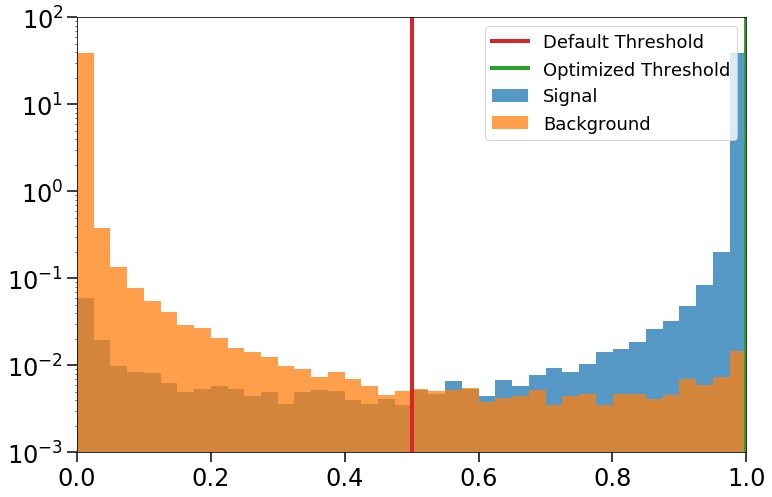

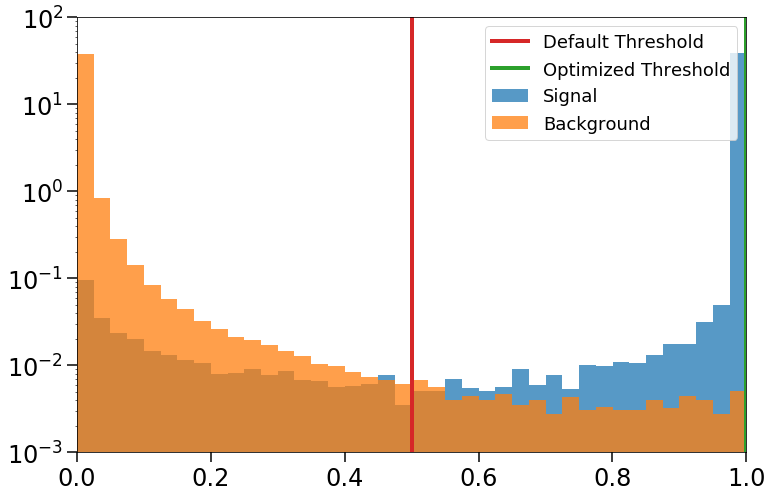

In [ ]:
background_names = ['Higgs', '4 Tops', 'No Higgs']
with plt.rc_context(get_settings()):
    for i, (model, result) in enumerate(zip(logreg_models, logreg_opt_results_sepbg)):
        plt.figure(i)
        bin_edges, sig_bins, bg_bins = model.predict_hist(data[i][1][0], data[i][1][1], num_bins=40, sepbg=False)
        plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", label="Signal")
        plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", label="Background")
        plt.plot([0.5]*2, [10**-3, 10**2], label='Default Threshold', c='tab:red')
        plt.plot([result[0]]*2, [10**-3, 10**2], label='Optimized Threshold', c='tab:green')
        plt.yscale('log')
        plt.gca().set_ylim(10**-3, 10**2)
        plt.gca().set_xlim(0, 1)
        plt.legend()

## Random Forests

Having comprehensively explored logistic regression, we can ramp up our performance by adopting a more sophisticated machine learning model: random forests. In particular, we can implement the random forest methodology using `sklearn.ensemble.RandomForestClassifier`

### Initializing and Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
time_before = getTime(form='m')
randforest_m350G_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m350G_model.fit(*data[0][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 37.383 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m500G_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m500G_model.fit(*data[1][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 40.067 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m1T_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m1T_model.fit(*data[2][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 43.667 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m2T_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m2T_model.fit(*data[3][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 40.633 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m4T_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m4T_model.fit(*data[4][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 36.983 minutes)


### Evaluation

We now iterate over all of the performance evaluation strategies we employed for logistic regression.

In [ ]:
randforest_models = [
    randforest_m350G_model, randforest_m500G_model, randforest_m1T_model, randforest_m2T_model, randforest_m4T_model]

In [ ]:
time_before = getTime()
randforest_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(data[i][1][1], preds=data[i][1][0]), 
                                          fpr=model.fpr(data[i][1][1], preds=data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(randforest_models, signal_yields))]
for sig, mass in zip(randforest_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> random forests gives significance of 26.736 sigma w/o separated backgrounds
Z' mass = 500 GeV --> random forests gives significance of 13.334 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> random forests gives significance of 3.066 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> random forests gives significance of 0.37 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> random forests gives significance of 0.008 sigma w/o separated backgrounds
(Runtime: 170 seconds)


In [ ]:
time_before = getTime()
randforest_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(data[i][1][1], preds=data[i][1][0]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True) 
                       for i, (model, signal_yield) in enumerate(zip(randforest_models, signal_yields))]
for sig, mass in zip(randforest_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> random forests gives significance of 27.234 sigma w/ separated backgrounds
Z' mass = 500 GeV --> random forests gives significance of 13.83 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> random forests gives significance of 3.1 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> random forests gives significance of 0.37 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> random forests gives significance of 0.008 sigma w/ separated backgrounds
(Runtime: 110 seconds)


In [ ]:
time_before = getTime(form='m')
randforest_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, data[i][1][0], data[i][1][1],
                                                       sepbg=False) 
                                  for i, (model, signal_yield) in enumerate(zip(randforest_models, signal_yields))]
randforest_opt_sigs_nosepbg = [result[1] for result in randforest_opt_results_nosepbg]
for sig, mass in zip(randforest_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> random forests gives optimized sign. of 63.289 sigma w/o separated backgrounds
Z' mass = 500 GeV --> random forests gives optimized sign. of 42.89 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> random forests gives optimized sign. of 16.483 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> random forests gives optimized sign. of 2.878 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> random forests gives optimized sign. of 0.12 sigma w/o separated backgrounds
(Runtime: 5.816 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, data[i][1][0], data[i][1][2],
                                                     sepbg=True)
                                for i, (model, signal_yield) in enumerate(zip(randforest_models, signal_yields))]
randforest_opt_sigs_sepbg = [result[1] for result in randforest_opt_results_sepbg]
for sig, mass in zip(randforest_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> random forests gives optimized sign. of 54.244 sigma w/ separated backgrounds
Z' mass = 500 GeV --> random forests gives optimized sign. of 37.511 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> random forests gives optimized sign. of 13.108 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> random forests gives optimized sign. of 2.431 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> random forests gives optimized sign. of 0.073 sigma w/ separated backgrounds
(Runtime: 5.667 minutes)


In [ ]:
randforest_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(randforest_sigs_nosepbg), kind='cubic')
randforest_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(randforest_sigs_sepbg), kind='cubic')
randforest_opt_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(randforest_opt_sigs_nosepbg), kind='cubic')
randforest_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(randforest_opt_sigs_sepbg), kind='linear')

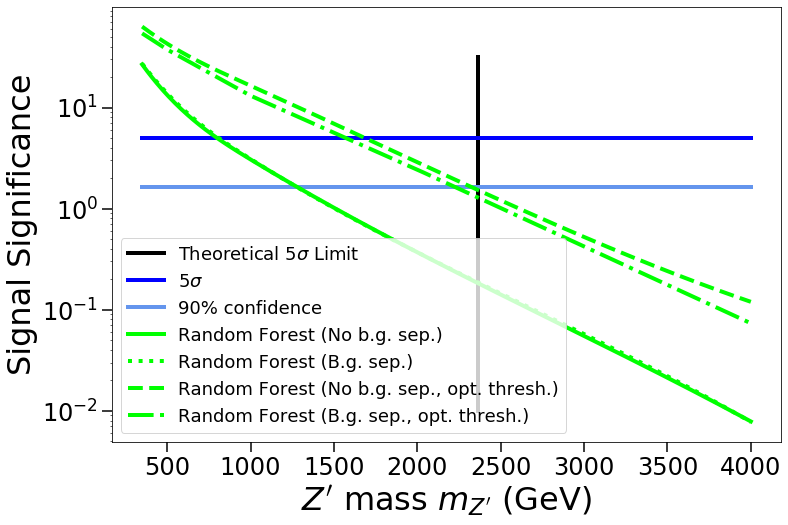

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 1.5, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**randforest_sigs_nosepbg_f(m) for m in sample_masses], 
        label='Random Forest (No b.g. sep.)', 
        c='lime')
    plt.plot(
        sample_masses, [10**randforest_sigs_sepbg_f(m) for m in sample_masses], 
        label='Random Forest (B.g. sep.)', 
        c='lime', linestyle=':')
    plt.plot(
        sample_masses, [10**randforest_opt_sigs_nosepbg_f(m) for m in sample_masses], 
        label='Random Forest (No b.g. sep., opt. thresh.)', 
        c='lime', linestyle='--')
    plt.plot(
        sample_masses, [10**randforest_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Random Forest (B.g. sep., opt. thresh.)', 
        c='lime', linestyle='-.')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

## Gradient Boosting

Now we can take yet another step up by using a gradient boosting model. In particular, we'll use the `xgboost` library, which shares `sk-learn`'s API but provides substantial computational speed-up for gradient boosting models. 

### Initializing and Training

In [ ]:
from xgboost import XGBClassifier

In [ ]:
time_before = getTime(form='m')
xgradboost_m350G_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m350G_model.fit(*data[0][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[04:47:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 36.433 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m500G_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m500G_model.fit(*data[1][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[05:23:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 36.2 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m1T_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m1T_model.fit(*data[2][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[06:00:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 35.484 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m2T_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m2T_model.fit(*data[3][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[06:35:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 37.766 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m4T_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m4T_model.fit(*data[4][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[07:13:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 34.9 minutes)


### Evaluation

In [ ]:
xgradboost_models = [
    xgradboost_m350G_model, xgradboost_m500G_model, xgradboost_m1T_model, xgradboost_m2T_model, xgradboost_m4T_model]

In [ ]:
time_before = getTime()
xgradboost_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(data[i][1][1], preds=data[i][1][0]), 
                                          fpr=model.fpr(data[i][1][1], preds=data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(xgradboost_models, signal_yields))]
for sig, mass in zip(xgradboost_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> gradient boosting gives significance of 33.524 sigma w/o separated backgrounds
Z' mass = 500 GeV --> gradient boosting gives significance of 17.511 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> gradient boosting gives significance of 4.07 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> gradient boosting gives significance of 0.465 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> gradient boosting gives significance of 0.007 sigma w/o separated backgrounds
(Runtime: 44 seconds)


In [ ]:
time_before = getTime()
xgradboost_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(data[i][1][1], preds=data[i][1][0]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True) 
                       for i, (model, signal_yield) in enumerate(zip(xgradboost_models, signal_yields))]
for sig, mass in zip(xgradboost_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> gradient boosting gives significance of 28.158 sigma w/ separated backgrounds
Z' mass = 500 GeV --> gradient boosting gives significance of 14.851 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> gradient boosting gives significance of 3.426 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> gradient boosting gives significance of 0.363 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> gradient boosting gives significance of 0.005 sigma w/ separated backgrounds
(Runtime: 28 seconds)


In [ ]:
time_before = getTime(form='m')
xgradboost_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, data[i][1][0], data[i][1][1],
                                                       sepbg=False) 
                                  for i, (model, signal_yield) in enumerate(zip(xgradboost_models, signal_yields))]
xgradboost_opt_sigs_nosepbg = [result[1] for result in xgradboost_opt_results_nosepbg]
for sig, mass in zip(xgradboost_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting forests gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> gradient boosting forests gives optimized sign. of 79.138 sigma w/o separated backgrounds
Z' mass = 500 GeV --> gradient boosting forests gives optimized sign. of 54.933 sigma w/o separated backgrounds
Z' mass = 1000 GeV --> gradient boosting forests gives optimized sign. of 20.962 sigma w/o separated backgrounds
Z' mass = 2000 GeV --> gradient boosting forests gives optimized sign. of 7.163 sigma w/o separated backgrounds
Z' mass = 4000 GeV --> gradient boosting forests gives optimized sign. of 1.021 sigma w/o separated backgrounds
(Runtime: 5.583 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, data[i][1][0], data[i][1][2],
                                                     sepbg=True)
                                for i, (model, signal_yield) in enumerate(zip(xgradboost_models, signal_yields))]
xgradboost_opt_sigs_sepbg = [result[1] for result in xgradboost_opt_results_sepbg]
for sig, mass in zip(xgradboost_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> gradient boosting gives optimized sign. of 67.963 sigma w/ separated backgrounds
Z' mass = 500 GeV --> gradient boosting gives optimized sign. of 46.62 sigma w/ separated backgrounds
Z' mass = 1000 GeV --> gradient boosting gives optimized sign. of 17.07 sigma w/ separated backgrounds
Z' mass = 2000 GeV --> gradient boosting gives optimized sign. of 7.148 sigma w/ separated backgrounds
Z' mass = 4000 GeV --> gradient boosting gives optimized sign. of 1.021 sigma w/ separated backgrounds
(Runtime: 5.25 minutes)


In [ ]:
xgradboost_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(xgradboost_sigs_nosepbg), kind='cubic')
xgradboost_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(xgradboost_sigs_sepbg), kind='cubic')
xgradboost_opt_sigs_nosepbg_f = scipy.interpolate.interp1d(masses, np.log10(xgradboost_opt_sigs_nosepbg), kind='cubic')
xgradboost_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(xgradboost_opt_sigs_sepbg), kind='linear')

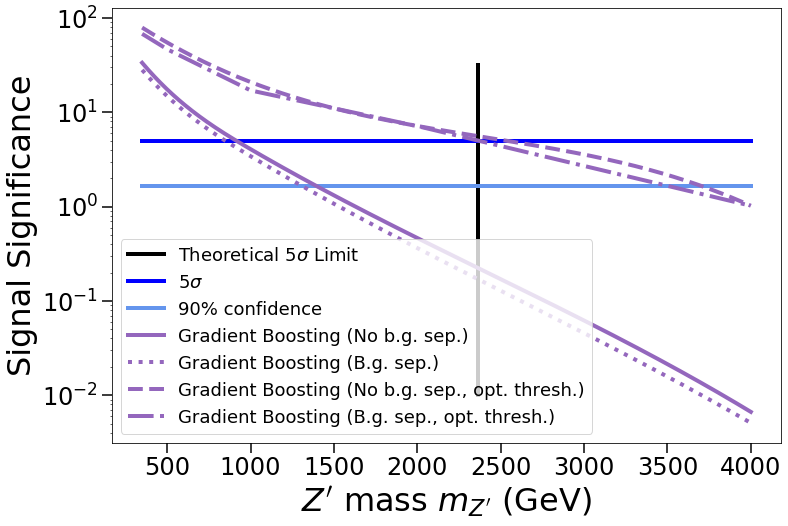

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 1.5, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**xgradboost_sigs_nosepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting (No b.g. sep.)', 
        c='tab:purple')
    plt.plot(
        sample_masses, [10**xgradboost_sigs_sepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting (B.g. sep.)', 
        c='tab:purple', linestyle=':')
    plt.plot(
        sample_masses, [10**xgradboost_opt_sigs_nosepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting (No b.g. sep., opt. thresh.)', 
        c='tab:purple', linestyle='--')
    plt.plot(
        sample_masses, [10**xgradboost_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting (B.g. sep., opt. thresh.)', 
        c='tab:purple', linestyle='-.')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

As a bonus, let's now compare the performance between machine learning methodologies for, say, the optimized threshold + background separation case (as this is the most realistic option).

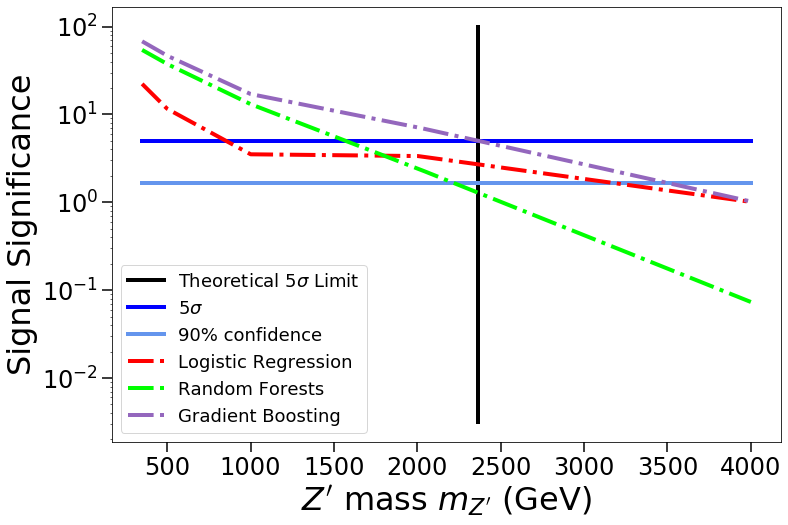

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2.5, 2, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**logreg_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Logistic Regression', 
        c='red', linestyle='-.')
    plt.plot(
        sample_masses, [10**randforest_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Random Forests', 
        c='lime', linestyle='-.')
    plt.plot(
        sample_masses, [10**xgradboost_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting', 
        c='tab:purple', linestyle='-.')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

## Feature Importance

Our models differentiate between signal and background using the features we provide, but in the eyes of the models not all features are created equal. Indeed, trained models assign importances to their features: accessing these allows us to understand precisely where our discriminating power comes from.

Our `bcml_model` class provides some functionality for accessing and analyzing feature importance, which we'll now explore. 

### Printing Values 

We can access feature importances through the `bcml_model.sorted_feature_importance` method (except for when we're doing logistic regression, but more on that in a second). Let's start by constructing a helpful function for printing out the data returned by the aforementioned method.

In [ ]:
max_feature_len = max([len(feature) for feature in get47Dfeatures()])

def printFeatureImportances(feature_importances, num=10, hasSign=False):
    feature_importances = feature_importances[:num]
    for i, (feature, importance) in enumerate(feature_importances):
        if hasSign:
            sign = '+' if importance >= 0 else '-'
            print('{4:2}. {0:{1}} {3}{2:.4f}'.format(feature, max_feature_len + 3, np.abs(importance), sign, i+1))
        else:
            print('{3:2}. {0:{1}} {2:.4f}'.format(feature, max_feature_len + 3, importance, i+1))

Now we can look at feature importances, starting with our logistic regression model. Unfortunately, while make `sk-learn` models have built-in methods for accessing feature importance (which our `bcml_model` class exploits), logistic regression lacks this: instead, however, we can just look at the magnitudes of the learned coefficients, which amount to the same thing. Consequently, we'll adapt some of the code in `bcml_model.sorted_feature_importance` to explore the logistic regression model coefficients.

In [ ]:
features = get47Dfeatures()
lr_feature_importances_raw = [model.model[-1].coef_[0] for model in logreg_models]
ranked_indices = [np.argsort(-np.abs(importances)) for importances in lr_feature_importances_raw]
lr_feature_importances = [
    [[features[i], importances[i]] for i in indices] for importances, indices in zip(lr_feature_importances_raw, ranked_indices)]

In [ ]:
for mass, feature_importance in zip(masses, lr_feature_importances):
    print(f"Z' mass = {mass}")
    printFeatureImportances(feature_importance, hasSign=True)
    if mass != masses[-1]:
        print()

Z' mass = 350
 1. M j1 j2        -4.0128
 2. pT b1          +1.3718
 3. M b1 b2        -0.5675
 4. MT b1 l MET    +0.5563
 5. pT j2          -0.5362
 6. M b1 b4        +0.5027
 7. pT b3          +0.4634
 8. dR b1 b2       +0.4241
 9. pT l           -0.4114
10. MET            -0.3775

Z' mass = 500
 1. M j1 j2        -4.4617
 2. pT b1          +1.4807
 3. M b1 b4        +0.6866
 4. pT b2          +0.6386
 5. M b1 b2        +0.6010
 6. pT j2          -0.5372
 7. M b1 b3        +0.4356
 8. MT b1 l MET    +0.3963
 9. MT b4 l MET    -0.3363
10. pT l           -0.3351

Z' mass = 1000
 1. M j1 j2        -5.0810
 2. M b1 b2        +4.2592
 3. M b1 b3        +1.9567
 4. M b1 b4        +1.5468
 5. pT b3          -1.0996
 6. dR b1 b2       -0.8572
 7. pT b1          +0.6903
 8. M b2 b3        +0.6769
 9. dR b1 b4       -0.5659
10. M b2 b4        +0.4443

Z' mass = 2000
 1. M b1 b2        +5.8614
 2. M j1 j2        -3.7362
 3. M b1 b3        +2.3241
 4. M b1 b4        +1.6215
 5. pT b3          -1

Now let's look at random forests: at this point, we're free to use the built-in function.

In [ ]:
rf_feature_importances = [model.sorted_feature_importance(get47Dfeatures()) for model in randforest_models]

In [ ]:
for mass, feature_importance in zip(masses, rf_feature_importances):
    print(f"Z' mass = {mass}")
    printFeatureImportances(feature_importance)
    if mass != masses[-1]:
        print()

Z' mass = 350
 1. M b1 b2        0.1381
 2. pT b1          0.1233
 3. M j1 j2        0.1004
 4. M b1 b3        0.0745
 5. pT b2          0.0648
 6. M b1 b4        0.0517
 7. pT b3          0.0396
 8. M b2 b4        0.0286
 9. pT j2          0.0284
10. M b2 b3        0.0271

Z' mass = 500
 1. M b1 b2        0.2194
 2. pT b1          0.1422
 3. pT b2          0.0804
 4. M j1 j2        0.0769
 5. M b1 b3        0.0619
 6. pT b3          0.0531
 7. M b1 b4        0.0504
 8. M b2 b3        0.0370
 9. MT b1 l MET    0.0245
10. M b2 b4        0.0226

Z' mass = 1000
 1. M b1 b2        0.2666
 2. pT b1          0.1723
 3. pT b2          0.1406
 4. M b1 b3        0.0878
 5. pT b3          0.0455
 6. M b2 b3        0.0437
 7. MT b1 l MET    0.0434
 8. M j1 j2        0.0325
 9. M b2 b4        0.0284
10. M b1 b4        0.0209

Z' mass = 2000
 1. M b1 b2        0.2116
 2. pT b1          0.1761
 3. pT b2          0.1580
 4. M b1 b3        0.0926
 5. MT b1 l MET    0.0650
 6. M b1 b4        0.0483
 7.

Finally, we have the gradient boosting models.

In [ ]:
xgb_feature_importances = [model.sorted_feature_importance(get47Dfeatures()) for model in xgradboost_models]

In [ ]:
for mass, feature_importance in zip(masses, xgb_feature_importances):
    print(f"Z' mass = {mass}")
    printFeatureImportances(feature_importance)
    if mass != masses[-1]:
        print()

Z' mass = 350
 1. M b1 b2        0.2680
 2. M j1 j2        0.1726
 3. M b1 b3        0.0763
 4. pT b1          0.0646
 5. M b1 b4        0.0594
 6. M b3 b4        0.0384
 7. dR b1 b2       0.0366
 8. pT b4          0.0349
 9. M b2 b3        0.0331
10. M b2 b4        0.0331

Z' mass = 500
 1. M b1 b2        0.4526
 2. M j1 j2        0.1334
 3. M b1 b3        0.0773
 4. M b1 b4        0.0444
 5. pT b1          0.0368
 6. dR b1 b2       0.0315
 7. M b2 b3        0.0233
 8. M b3 b4        0.0225
 9. dR b1 b3       0.0208
10. M b2 b4        0.0206

Z' mass = 1000
 1. M b1 b2        0.7459
 2. M b1 b3        0.0615
 3. M j1 j2        0.0422
 4. M b1 b4        0.0309
 5. pT b1          0.0190
 6. M b2 b3        0.0124
 7. dR b1 b2       0.0112
 8. M b2 b4        0.0081
 9. M b3 b4        0.0065
10. MT l MET       0.0054

Z' mass = 2000
 1. M b1 b2        0.9073
 2. M b1 b3        0.0301
 3. M b1 b4        0.0111
 4. M j1 j2        0.0110
 5. M b2 b3        0.0050
 6. pT b1          0.0039
 7.

### Visualization

Reading out printed feature importances is fine, but it might be nice to try and visualize how feature importance varies with $m_{Z'}$ for different model types. We can do this with some list manipulation and interpolation as follows, beginning once more with our logistic regression models.

In [ ]:
num = 18
lr_features = [[feature for feature, importance in elem] for elem in lr_feature_importances]
lr_best_features = list(set.intersection(*[set(elem[:num]) for elem in lr_features]))
lr_best_features_and_imps = [
    [feature, [elem[features.index(feature)][1] for elem, features in zip(lr_feature_importances, lr_features)]] 
    for feature in lr_best_features]
lr_fs = [scipy.interpolate.interp1d(masses, np.abs(importances), kind='quadratic') 
         for feature, importances in lr_best_features_and_imps]

This chunk of code works roughly by taking the intersection of the sets of top `num` features for the various $Z'$ masses (to get the most important features over all), grabbing the feature importance for each of these most importance features at each $m_{Z'}$ value, then interpolating functions of importance vs $m_{Z'}$ for each of the important features.

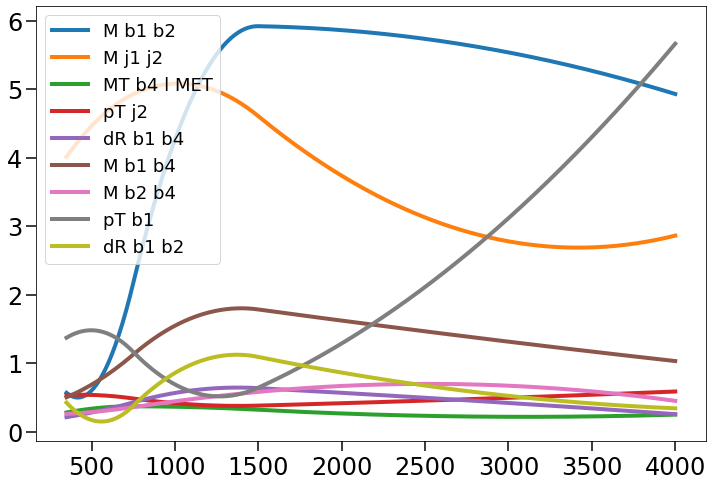

In [ ]:
sample_masses = np.linspace(masses[0], masses[-1], 500)
with plt.rc_context(get_settings()):
    for f, feature in zip(lr_fs, lr_best_features):
        plt.plot(sample_masses, f(sample_masses), label=feature)
    plt.legend()

Now we proceed onto random forests.

In [ ]:
num = 10
rf_features = [[feature for feature, importance in elem] for elem in rf_feature_importances]
rf_best_features = list(set.intersection(*[set(elem[:num]) for elem in rf_features]))
rf_best_features_and_imps = [
    [feature, [elem[features.index(feature)][1] for elem, features in zip(rf_feature_importances, rf_features)]] 
    for feature in rf_best_features]
rf_fs = [scipy.interpolate.interp1d(masses, np.abs(importances), kind='quadratic') 
         for feature, importances in rf_best_features_and_imps]

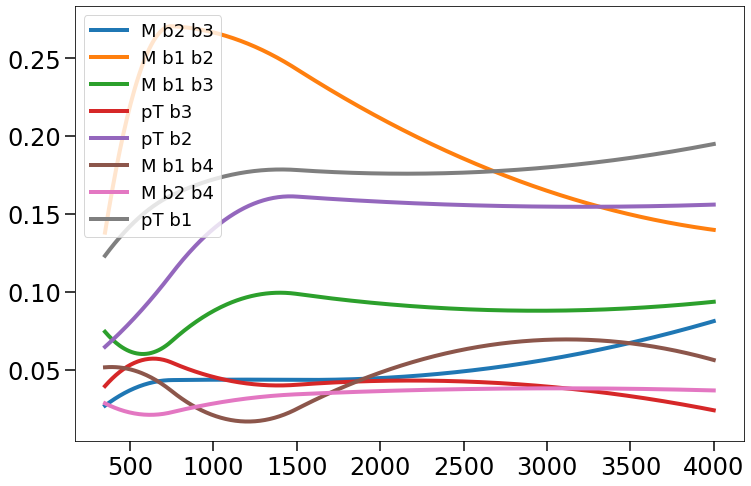

In [ ]:
sample_masses = np.linspace(masses[0], masses[-1], 500)
with plt.rc_context(get_settings()):
    for f, feature in zip(rf_fs, rf_best_features):
        plt.plot(sample_masses, f(sample_masses), label=feature)
    plt.legend()

And finally onto gradient boosting.

In [ ]:
num = 10
xgb_features = [[feature for feature, importance in elem] for elem in xgb_feature_importances]
xgb_best_features = list(set.intersection(*[set(elem[:num]) for elem in xgb_features]))
xgb_best_features_and_imps = [
    [feature, [elem[features.index(feature)][1] for elem, features in zip(xgb_feature_importances, xgb_features)]] 
    for feature in xgb_best_features]
xgb_fs = [scipy.interpolate.interp1d(masses, np.abs(importances), kind='quadratic') 
         for feature, importances in xgb_best_features_and_imps]

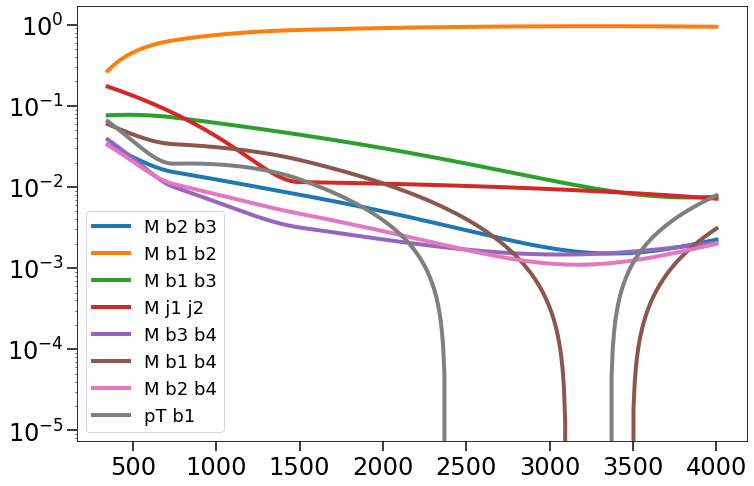

In [ ]:
sample_masses = np.linspace(masses[0], masses[-1], 500)
with plt.rc_context(get_settings()):
    for f, feature in zip(xgb_fs, xgb_best_features):
        plt.plot(sample_masses, f(sample_masses), label=feature)
    plt.yscale('log')
    plt.legend()

## TPR-FPR Curves

### Setup

Consider the situation at hand. We want to maximize signal significance $\mathcal{S}$, which is a function of TPR, FPR, and $m_{Z'}$ (via $\sigma_s$). Visualizing a function $\mathbb{R}^3 \to \mathbb{R}$ is hard: we're going to have to reduce our dimensionality somehow. First, recall that we are really interested in achieving discovery potential, $5\sigma$. Given a TPR and FPR, there will be a range of $m_{Z'}$ values which yield $\mathcal{S} \geq 5$. More specifically, because cross section scales inversely with $m_{Z'}$, there will be a maximal $m_{Z'}$ for fixed TPR and FPR that yields $\mathcal{S} \geq 5$ (i.e., the mass such that $\mathcal{S} = 5$). We can construct a heatmap which uses color to depict that maximal mass sensitivity as a function of TPR, FPR for the case of the $Z'$ signal cross sections we've been considering. 

The `cross_section_helper` class allows us to plot this heatmap via the `cross_section_helper.max_mass_sens_versus_tpr_fpr` method.

In [ ]:
cvalues = [500, 750, 1000, 1500, 2000]
clabels = [str(val) for val in cvalues]
manual = [(0.85, -1), (0.85, -2), (0.85, -3), (0.85, -3.5), (0.85, -6)]
tpr_bounds = (0.05,1)
fpr_bounds = (10**-7, 0.5)
colors = np.linspace(0.3, 0.8, 5)

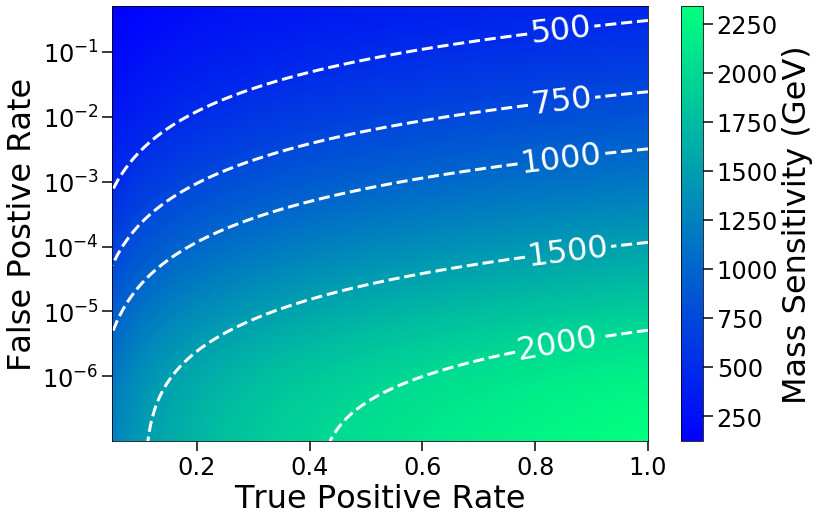

In [ ]:
zp_cs.max_mass_sens_versus_tpr_fpr(plot=True, sig=5, lumi=3000, tpr_bounds=tpr_bounds, fpr_bounds=fpr_bounds, res=1000, 
                                   cvalues=cvalues, clabels=clabels, manual=manual);

### Logistic Regression

Recall that varying the threshold on a given model yields a set of (TPR, FPR) pairs: we can interpret these as points sweeping out a curve in TPR-FPR space. Threshold optimization, then, entails selecting the point on the curve which maximizes signal significance. In the language of our above heatmap, this means picking the point on the curve where the mass sensitivity is highest. It is therefore insightful to overlay the TPR-FPR curves which our models induce on top of the heatmap we've just established. Moreover, we will emphasize the points on the curve corresponding to both the default threshold ($0.5$) and the optimized threshold for each model, to provide yet another visualization of the improvement. We will employ this procedure first for our logistic regression models, reusing some of the output of `bcml_model.best_threshold` while also exploiting `bcml_model.tpr` and `bcml_model.fpr`.

In [ ]:
# takes longer
lr_default_tprs = [model.tpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(logreg_models, data)]
lr_default_fprs = [model.fpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(logreg_models, data)]

In [ ]:
lr_sample_tprs = [
    np.linspace(result[-2][0] + 1e-5, result[-2][-1] - 1e-5, 200) 
    for result in logreg_opt_results_nosepbg]
lr_tpr_fpr_fs = [
    scipy.interpolate.interp1d(result[-2], np.log10(np.where(result[-1]==0,1.2e-7,result[-1])), kind='linear')
    for result in logreg_opt_results_nosepbg]
lr_optimized_tpr = [result[-4] for result in logreg_opt_results_nosepbg]
lr_optimized_fpr = [result[-3] if result[-3] > 0 else 1.2e-7 for result in logreg_opt_results_nosepbg]

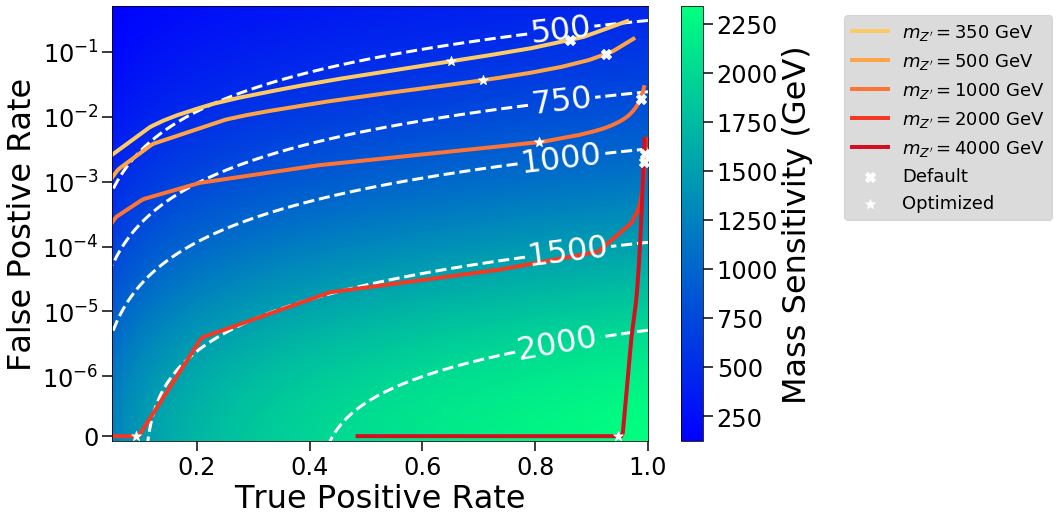

In [ ]:
zp_cs.max_mass_sens_versus_tpr_fpr(plot=True, sig=5, lumi=3000, tpr_bounds=tpr_bounds, fpr_bounds=fpr_bounds, res=1000, 
                                   cvalues=cvalues, clabels=clabels, manual=manual);
with plt.rc_context(get_settings()):
    for result, f, sample_tprs, mass, color in zip(logreg_opt_results_nosepbg, lr_tpr_fpr_fs, lr_sample_tprs, masses, colors):
        plt.plot(sample_tprs, f(sample_tprs), c=plt.cm.YlOrRd(color), label=r"$m_{Z'} =" + f'{mass}$ GeV')
    plt.scatter(lr_default_tprs, np.log10(lr_default_fprs), c='white', label='Default', zorder=10, marker='X')
    plt.scatter(lr_optimized_tpr, np.log10(lr_optimized_fpr), c='white', label='Optimized', zorder=10, marker='*')
    plt.legend(bbox_to_anchor=(1.35,1), loc="upper left", facecolor='lightgrey')
    plt.xlim(*tpr_bounds);
    plt.ylim(*np.log10(fpr_bounds));
    plt.yticks(list(plt.yticks()[0]) + [np.log10(1.2e-7)], list(plt.yticks()[1]) + ['0'])

It's most insightful to plot the FPR axis using log scale, but this prevents us from visualizing portions of the TPR-FPR curves where $\text{FPR} = 0$, which does happen sometimes. To combat this, we implement a hack: whenever $\text{FPR} = 0$, we bump it up to a small (but non-zero) value, and then manually label that FPR value $0$. This is what you're seeing above.

### Random Forests

We now go through the same procedure for our random forests models.

In [ ]:
# takes longer
rf_default_tprs = [model.tpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(randforest_models, data)]
rf_default_fprs = [model.fpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(randforest_models, data)]

In [ ]:
rf_sample_tprs = [
    np.linspace(result[-2][0] + 1e-5, result[-2][-1] - 1e-5, 200) 
    for result in randforest_opt_results_nosepbg]
rf_tpr_fpr_fs = [
    scipy.interpolate.interp1d(result[-2], np.log10(np.where(result[-1]==0,1.2e-7,result[-1])), kind='linear')
    for result in randforest_opt_results_nosepbg]
rf_optimized_tpr = [result[-4] for result in randforest_opt_results_nosepbg]
rf_optimized_fpr = [result[-3] if result[-3] > 0 else 1.2e-7 for result in randforest_opt_results_nosepbg]

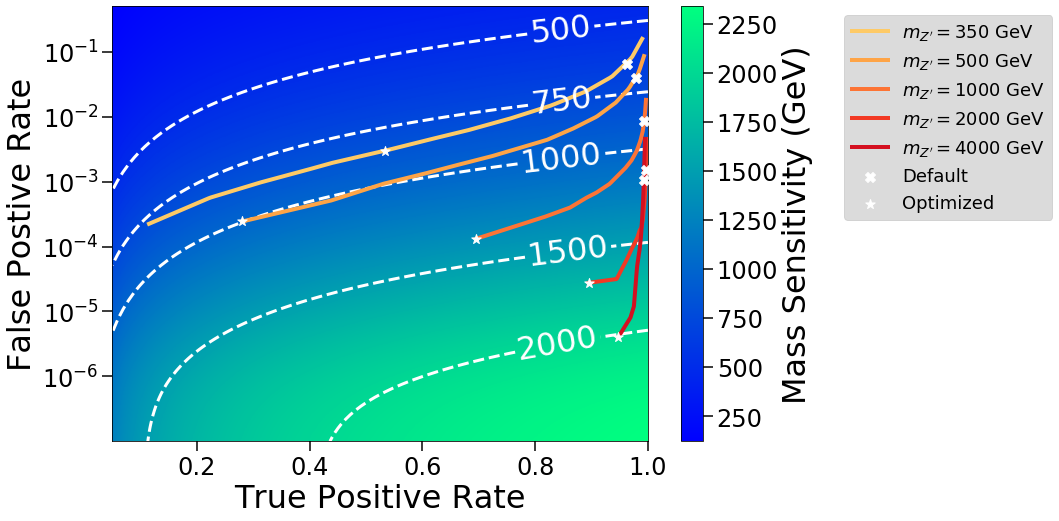

In [ ]:
zp_cs.max_mass_sens_versus_tpr_fpr(plot=True, sig=5, lumi=3000, tpr_bounds=tpr_bounds, fpr_bounds=fpr_bounds, res=1000, 
                                   cvalues=cvalues, clabels=clabels, manual=manual);
with plt.rc_context(get_settings()):
    for result, f, sample_tprs, mass, color in zip(randforest_opt_results_nosepbg, rf_tpr_fpr_fs, rf_sample_tprs, masses, colors):
        plt.plot(sample_tprs, f(sample_tprs), c=plt.cm.YlOrRd(color), label=r"$m_{Z'} =" + f'{mass}$ GeV')
    plt.scatter(rf_default_tprs, np.log10(rf_default_fprs), c='white', label='Default', zorder=10, marker='X')
    plt.scatter(rf_optimized_tpr, np.log10(rf_optimized_fpr), c='white', label='Optimized', zorder=10, marker='*')
    plt.legend(bbox_to_anchor=(1.35,1), loc="upper left", facecolor='lightgrey')
    plt.xlim(*tpr_bounds);
    plt.ylim(*np.log10(fpr_bounds));

### Gradient Boosting

Finally, we have the gradient boosting models.

In [ ]:
# longer
xgb_default_tprs = [model.tpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(xgradboost_models, data)]
xgb_default_fprs = [model.fpr(data_row[1][1], preds=data_row[1][0]) for model, data_row in zip(xgradboost_models, data)]

In [ ]:
# shorter
xgb_sample_tprs = [
    np.linspace(result[-2][0] + 1e-5, result[-2][-1] - 1e-5, 200) 
    for result in xgradboost_opt_results_nosepbg]
xgb_tpr_fpr_fs = [
    scipy.interpolate.interp1d(result[-2], np.log10(np.where(result[-1]==0,1.2e-7,result[-1])), kind='linear')
    for result in xgradboost_opt_results_nosepbg]
xgb_optimized_tpr = [result[-4] for result in xgradboost_opt_results_nosepbg]
xgb_optimized_fpr = [result[-3] if result[-3] > 0 else 1.2e-7 for result in xgradboost_opt_results_nosepbg]

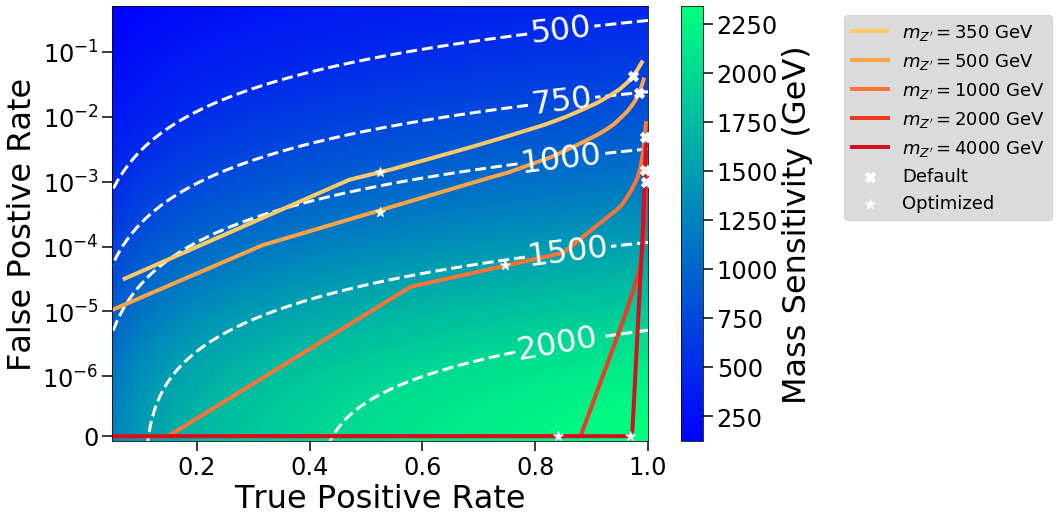

In [ ]:
zp_cs.max_mass_sens_versus_tpr_fpr(plot=True, sig=5, lumi=3000, tpr_bounds=tpr_bounds, fpr_bounds=fpr_bounds, res=1000, 
                                   cvalues=cvalues, clabels=clabels, manual=manual);
with plt.rc_context(get_settings()):
    for result, f, sample_tprs, mass, color in zip(xgradboost_opt_results_nosepbg, xgb_tpr_fpr_fs, xgb_sample_tprs, masses, colors):
        plt.plot(sample_tprs, f(sample_tprs), c=plt.cm.YlOrRd(color), label=r"$m_{Z'} =" + f'{mass}$ GeV')
    plt.scatter(xgb_default_tprs, np.log10(xgb_default_fprs), c='white', label='Default', zorder=10, marker='X')
    plt.scatter(xgb_optimized_tpr, np.log10(xgb_optimized_fpr), c='white', label='Optimized', zorder=10, marker='*')
    plt.legend(bbox_to_anchor=(1.35,1), loc="upper left", facecolor='lightgrey')
    plt.xlim(*tpr_bounds);
    plt.ylim(*np.log10(fpr_bounds));
    plt.yticks(list(plt.yticks()[0]) + [np.log10(1.2e-7)], list(plt.yticks()[1]) + ['0'])

## CSV Files

Statistical analyses of real data at experiments like CMS and ATLAS sometimes make use of so-called "shape-based analyses" where histograms of events are processed bin by bin in a search for signal significance. What follows is some code I produced (using the built-in `bcml_model.predict_hist` function) to extract and save bin contents (using the [pandas](https://pandas.pydata.org/) library) for histograms of events where our x-coordinate variable is signal probability, as predicted by each of our models.

In [ ]:
logreg_models = [logreg_m350G_model, logreg_m500G_model, logreg_m1T_model, logreg_m2T_model, logreg_m4T_model]

In [ ]:
xgradboost_models = [
    xgradboost_m350G_model, xgradboost_m500G_model, xgradboost_m1T_model, xgradboost_m2T_model, xgradboost_m4T_model]

In [ ]:
background_names = ['Higgs', '4 Tops', 'No Higgs']
labels = ['Signal'] + [f'Background ({name})' for name in background_names]
all_names = [["Logistic Regression (m_Z' = {}) - {}".format(m, label) for label in labels] for m in masses] + \
    [["Random Forest (m_Z' = {}) - {}".format(m, label) for label in labels] for m in masses] + \
    [["Gradient Boosting (m_Z' = {}) - {}".format(m, label) for label in labels] for m in masses]

In [ ]:
num_binss = [50, 100, 250]
dfs = [pd.DataFrame() for n in num_binss]
conv = 10**15 / 10**12 # conv * lumi (in fb^{-1}) * cross sec (in pb) = # of events
lumi = 3000
signal_yields = [conv * lumi * sig_cs for sig_cs in sig_css]
background_yields = [conv * lumi * bg_cs for bg_cs in bg_css]
for num_bins, df in zip(num_binss, dfs):
    for model, signal_yield, names in zip(logreg_models + randforest_models + xgradboost_models, 
                                         signal_yields * 3, 
                                         all_names):
        sig_name = names[0]
        bg_names = names[1:]
        results = model.predict_hist(
            num_bins=num_bins, sepbg=True, sig_norm=signal_yield, bg_norm=background_yields)
        bin_edges = results[0]
        sig_bins = results[1]
        bg_binss = results[2:]
        df[sig_name] = sig_bins
        for bg_name, bg_bins in zip(bg_names, bg_binss):
            df[bg_name] = bg_bins
        df['Bin Edges'] = pd.Series(bin_edges)
    df.to_csv('./csvs/hist_data_{}bins.csv'.format(num_bins))

## Smeared Data

Our work thus far has been rather idealistic. This is true for a variety of reasons, but to cite a specific example, we are assuming effectively perfect experimental detectors: we are training our models on data which perfectly coincides with the kinematic behavior of (simulated) particles in events. In real life, detectors have associated uncertainties, which manifests itself in "noised" or "smeared" or "perturbed" data. We can gauge how well our models will do in a more realistic situation (i.e., with smeared data) by perturbing each of our data points, which we do now.

### Data Preparation

In [ ]:
perturb = 0.1

In [ ]:
from sklearn.model_selection import train_test_split
smeared_data = [
    train_test_split(
        np.concatenate([sig_data] + [bg_data[:int(len(sig_data)/3)] for bg_data in background_data]), 
        test_size=0.25, random_state=42) 
    for sig_data in signal_data]
smeared_data = [[[train[:,:-1], np.where(train[:,-1]==1,np.ones_like(train[:,-1]),np.zeros_like(train[:,-1])), train[:,-1]], 
                 [test[:,:-1], np.where(test[:,-1]==1,np.ones_like(test[:,-1]),np.zeros_like(test[:,-1])), test[:,-1]]] 
                 for train, test in smeared_data]

In [ ]:
time_before = getTime(form='m')
for i, elem in enumerate(smeared_data):
    smeared_data[i][0][0] = np.reshape(np.concatenate(
        [np.random.multivariate_normal(row, np.diag(np.abs(perturb * row))) for row in elem[0][0]], axis=0), (-1,47))
    smeared_data[i][1][0] = np.reshape(np.concatenate(
        [np.random.multivariate_normal(row, np.diag(np.abs(perturb * row))) for row in elem[1][0]], axis=0), (-1,47))
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 44.6 minutes)


### Logistic Regression

In [ ]:
logreg_m350G_smeared_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m350G_smeared_model.fit(*smeared_data[0][0][:2])

In [ ]:
logreg_m500G_smeared_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m500G_smeared_model.fit(*smeared_data[1][0][:2])

In [ ]:
logreg_m1T_smeared_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m1T_smeared_model.fit(*smeared_data[2][0][:2])

In [ ]:
logreg_m2T_smeared_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))
logreg_m2T_smeared_model.fit(*smeared_data[3][0][:2])

In [ ]:
# this one takes a little longer to converge, we'll bump up max_iter from 100 to 500
logreg_m4T_smeared_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression(max_iter=500)))
logreg_m4T_smeared_model.fit(*smeared_data[4][0][:2])

In [ ]:
logreg_smeared_models = [logreg_m350G_smeared_model, logreg_m500G_smeared_model, logreg_m1T_smeared_model, 
                         logreg_m2T_smeared_model, logreg_m4T_smeared_model]

In [ ]:
print(smeared_data[0][0][0].shape, smeared_data[0][1][0].shape)

(1499999, 47) (500000, 47)


In [ ]:
time_before = getTime()
logreg_smeared_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]), 
                                          fpr=model.fpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(logreg_smeared_models, signal_yields))]
for sig, mass in zip(logreg_smeared_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> logistic regression gives significance of 15.96 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> logistic regression gives significance of 8.38 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> logistic regression gives significance of 1.99 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> logistic regression gives significance of 0.273 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> logistic regression gives significance of 0.006 sigma w/o separated backgrounds (smeared data)
(Runtime: 32 seconds)


In [ ]:
time_before = getTime()
logreg_smeared_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(np.ones((len(indx[i][0]),)), preds=smeared_data[i][1][0][indx[i][0]]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=smeared_data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True)
                       for i, (model, signal_yield) in enumerate(zip(logreg_smeared_models, signal_yields))]
for sig, mass in zip(logreg_smeared_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> logistic regression gives significance of 19.799 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> logistic regression gives significance of 9.473 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> logistic regression gives significance of 1.982 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> logistic regression gives significance of 0.255 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> logistic regression gives significance of 0.006 sigma w/ separated backgrounds (smeared data)
(Runtime: 14 seconds)


In [ ]:
time_before = getTime(form='m')
logreg_smeared_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, smeared_data[i][1][0], smeared_data[i][1][1],
                                                           sepbg=False) 
                              for i, (model, signal_yield) in enumerate(zip(logreg_smeared_models, signal_yields))]
logreg_smeared_opt_sigs_nosepbg = [result[1] for result in logreg_smeared_opt_results_nosepbg]
for sig, mass in zip(logreg_smeared_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> logistic regression gives optimized sign. of 17.416 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> logistic regression gives optimized sign. of 10.125 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> logistic regression gives optimized sign. of 3.544 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> logistic regression gives optimized sign. of 2.376 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> logistic regression gives optimized sign. of 1.004 sigma w/o separated backgrounds (smeared data)
(Runtime: 4.65 minutes)


In [ ]:
time_before = getTime(form='m')
logreg_smeared_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, smeared_data[i][1][0], smeared_data[i][1][2],
                                                         sepbg=True)
                              for i, (model, signal_yield) in enumerate(zip(logreg_smeared_models, signal_yields))]
logreg_smeared_opt_sigs_sepbg = [result[1] for result in logreg_smeared_opt_results_sepbg]
for sig, mass in zip(logreg_smeared_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> logistic regression gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> logistic regression gives optimized sign. of 22.057 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> logistic regression gives optimized sign. of 11.495 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> logistic regression gives optimized sign. of 3.457 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> logistic regression gives optimized sign. of 3.315 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> logistic regression gives optimized sign. of 1.004 sigma w/ separated backgrounds (smeared data)
(Runtime: 4.833 minutes)


### Random Forests

In [ ]:
time_before = getTime(form='m')
randforest_m350G_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m350G_smeared_model.fit(*smeared_data[0][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 36.6 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m500G_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m500G_smeared_model.fit(*smeared_data[1][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 40.217 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m1T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m1T_smeared_model.fit(*smeared_data[2][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 44.366 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m2T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m2T_smeared_model.fit(*smeared_data[3][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 42.184 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_m4T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, n_jobs=-1)));
randforest_m4T_smeared_model.fit(*smeared_data[4][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

(Runtime: 38.05 minutes)


In [ ]:
randforest_smeared_models = [randforest_m350G_smeared_model, randforest_m500G_smeared_model, randforest_m1T_smeared_model, 
                             randforest_m2T_smeared_model, randforest_m4T_smeared_model]

In [ ]:
time_before = getTime()
randforest_smeared_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]), 
                                          fpr=model.fpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(randforest_smeared_models, signal_yields))]
for sig, mass in zip(randforest_smeared_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> random forests gives significance of 23.203 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> random forests gives significance of 12.314 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> random forests gives significance of 2.962 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> random forests gives significance of 0.355 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> random forests gives significance of 0.008 sigma w/o separated backgrounds (smeared data)
(Runtime: 217 seconds)


In [ ]:
time_before = getTime()
randforest_smeared_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(np.ones((len(indx[i][0]),)), preds=smeared_data[i][1][0][indx[i][0]]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=smeared_data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True)
                       for i, (model, signal_yield) in enumerate(zip(randforest_smeared_models, signal_yields))]
for sig, mass in zip(randforest_smeared_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> random forests gives significance of 26.641 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> random forests gives significance of 13.436 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> random forests gives significance of 3.0 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> random forests gives significance of 0.353 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> random forests gives significance of 0.007 sigma w/ separated backgrounds (smeared data)
(Runtime: 100 seconds)


In [ ]:
time_before = getTime(form='m')
randforest_smeared_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, smeared_data[i][1][0], smeared_data[i][1][1],
                                                           sepbg=False) 
                              for i, (model, signal_yield) in enumerate(zip(randforest_smeared_models, signal_yields))]
randforest_smeared_opt_sigs_nosepbg = [result[1] for result in randforest_smeared_opt_results_nosepbg]
for sig, mass in zip(randforest_smeared_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> random forests gives optimized sign. of 55.96 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> random forests gives optimized sign. of 23.886 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> random forests gives optimized sign. of 13.863 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> random forests gives optimized sign. of 3.714 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> random forests gives optimized sign. of 0.994 sigma w/o separated backgrounds (smeared data)
(Runtime: 7.066 minutes)


In [ ]:
time_before = getTime(form='m')
randforest_smeared_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, smeared_data[i][1][0], smeared_data[i][1][2],
                                                         sepbg=True)
                              for i, (model, signal_yield) in enumerate(zip(randforest_smeared_models, signal_yields))]
randforest_smeared_opt_sigs_sepbg = [result[1] for result in randforest_smeared_opt_results_sepbg]
for sig, mass in zip(randforest_smeared_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> random forests gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> random forests gives optimized sign. of 51.271 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> random forests gives optimized sign. of 21.723 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> random forests gives optimized sign. of 13.439 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> random forests gives optimized sign. of 3.199 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> random forests gives optimized sign. of 0.994 sigma w/ separated backgrounds (smeared data)
(Runtime: 6.684 minutes)


### Gradient Boosting

In [ ]:
time_before = getTime(form='m')
xgradboost_m350G_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m350G_smeared_model.fit(*smeared_data[0][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[00:53:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 44.933 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m500G_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m500G_smeared_model.fit(*smeared_data[1][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[01:37:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 45.933 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m1T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m1T_smeared_model.fit(*smeared_data[2][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[02:23:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 45.45 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m2T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m2T_smeared_model.fit(*smeared_data[3][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[03:09:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 48.934 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_m4T_smeared_model = bcml_model(
    make_pipeline(StandardScaler(), 
                  XGBClassifier(n_estimators=250, max_depth=7, learning_rate=0.1, nthread=4, use_label_encoder=False)));
xgradboost_m4T_smeared_model.fit(*smeared_data[4][0][:2])
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

[03:58:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(Runtime: 42.3 minutes)


In [ ]:
xgradboost_smeared_models = [xgradboost_m350G_smeared_model, xgradboost_m500G_smeared_model, xgradboost_m1T_smeared_model, 
                             xgradboost_m2T_smeared_model, xgradboost_m4T_smeared_model]

In [ ]:
time_before = getTime()
xgradboost_smeared_sigs_nosepbg = [model.significance(signal_yield, background_yield, 
                                          tpr=model.tpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]), 
                                          fpr=model.fpr(smeared_data[i][1][1], preds=smeared_data[i][1][0]),
                                          sepbg=False) 
                       for i, (model, signal_yield) in enumerate(zip(xgradboost_smeared_models, signal_yields))]
for sig, mass in zip(xgradboost_smeared_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives significance of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> gradient boosting gives significance of 27.652 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> gradient boosting gives significance of 15.171 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> gradient boosting gives significance of 3.752 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> gradient boosting gives significance of 0.465 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> gradient boosting gives significance of 0.007 sigma w/o separated backgrounds (smeared data)
(Runtime: 75 seconds)


In [ ]:
time_before = getTime()
xgradboost_smeared_sigs_sepbg = [model.significance(signal_yield, background_yields, 
                                          tpr=model.tpr(np.ones((len(indx[i][0]),)), preds=smeared_data[i][1][0][indx[i][0]]), 
                                          fpr=[model.fpr(np.zeros((len(indx[i][j]),)), preds=smeared_data[i][1][0][indx[i][j]]) 
                                               for j in range(1,4)],
                                          sepbg=True)
                       for i, (model, signal_yield) in enumerate(zip(xgradboost_smeared_models, signal_yields))]
for sig, mass in zip(xgradboost_smeared_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives significance of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime()
print(f"(Runtime: {time_after - time_before} seconds)")

Z' mass = 350 GeV --> gradient boosting gives significance of 28.297 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> gradient boosting gives significance of 14.964 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> gradient boosting gives significance of 3.487 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> gradient boosting gives significance of 0.374 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> gradient boosting gives significance of 0.006 sigma w/ separated backgrounds (smeared data)
(Runtime: 26 seconds)


In [ ]:
time_before = getTime(form='m')
xgradboost_smeared_opt_results_nosepbg = [model.best_threshold(signal_yield, background_yield, smeared_data[i][1][0], smeared_data[i][1][1],
                                                           sepbg=False) 
                              for i, (model, signal_yield) in enumerate(zip(xgradboost_smeared_models, signal_yields))]
xgradboost_smeared_opt_sigs_nosepbg = [result[1] for result in xgradboost_smeared_opt_results_nosepbg]
for sig, mass in zip(xgradboost_smeared_opt_sigs_nosepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives optimized sign. of {round(sig, 3)} sigma",
          "w/o separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> gradient boosting gives optimized sign. of 65.867 sigma w/o separated backgrounds (smeared data)
Z' mass = 500 GeV --> gradient boosting gives optimized sign. of 45.621 sigma w/o separated backgrounds (smeared data)
Z' mass = 1000 GeV --> gradient boosting gives optimized sign. of 20.097 sigma w/o separated backgrounds (smeared data)
Z' mass = 2000 GeV --> gradient boosting gives optimized sign. of 7.049 sigma w/o separated backgrounds (smeared data)
Z' mass = 4000 GeV --> gradient boosting gives optimized sign. of 1.022 sigma w/o separated backgrounds (smeared data)
(Runtime: 6.434 minutes)


In [ ]:
time_before = getTime(form='m')
xgradboost_smeared_opt_results_sepbg = [model.best_threshold(signal_yield, background_yields, smeared_data[i][1][0], smeared_data[i][1][2],
                                                         sepbg=True)
                              for i, (model, signal_yield) in enumerate(zip(xgradboost_smeared_models, signal_yields))]
xgradboost_smeared_opt_sigs_sepbg = [result[1] for result in xgradboost_smeared_opt_results_sepbg]
for sig, mass in zip(xgradboost_smeared_opt_sigs_sepbg, masses):
    print(f"Z' mass = {mass} GeV --> gradient boosting gives optimized sign. of {round(sig, 3)} sigma",
          "w/ separated backgrounds (smeared data)")
time_after = getTime(form='m')
print(f"(Runtime: {round(time_after - time_before,3)} minutes)")

Z' mass = 350 GeV --> gradient boosting gives optimized sign. of 57.659 sigma w/ separated backgrounds (smeared data)
Z' mass = 500 GeV --> gradient boosting gives optimized sign. of 40.115 sigma w/ separated backgrounds (smeared data)
Z' mass = 1000 GeV --> gradient boosting gives optimized sign. of 15.489 sigma w/ separated backgrounds (smeared data)
Z' mass = 2000 GeV --> gradient boosting gives optimized sign. of 7.017 sigma w/ separated backgrounds (smeared data)
Z' mass = 4000 GeV --> gradient boosting gives optimized sign. of 1.022 sigma w/ separated backgrounds (smeared data)
(Runtime: 7.15 minutes)


### Performance Comparison

In [ ]:
logreg_smeared_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(logreg_smeared_opt_sigs_sepbg), kind='linear')
randforest_smeared_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(randforest_smeared_opt_sigs_sepbg), kind='linear')
xgradboost_smeared_opt_sigs_sepbg_f = scipy.interpolate.interp1d(masses, np.log10(xgradboost_smeared_opt_sigs_sepbg), kind='linear')

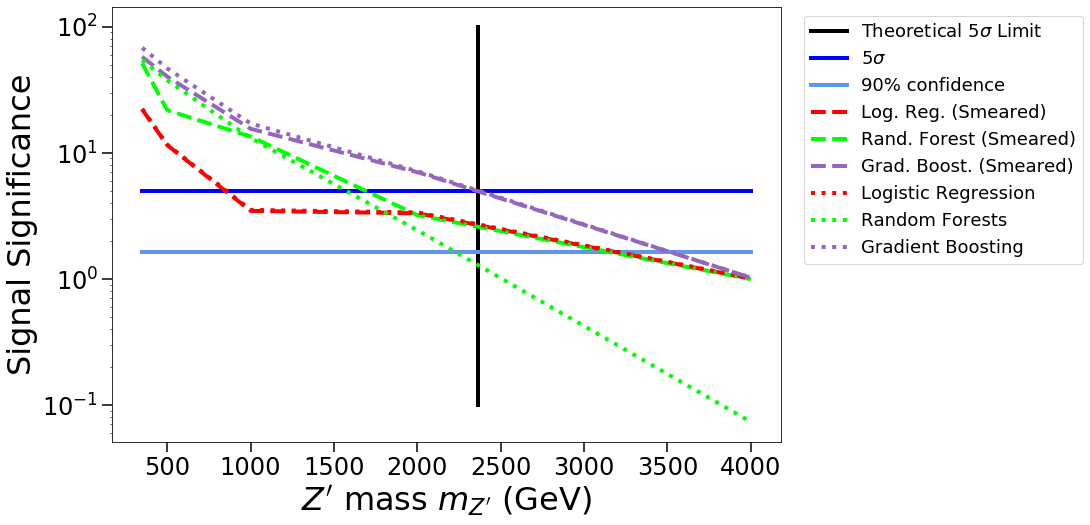

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-1, 2, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**logreg_smeared_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Log. Reg. (Smeared)', 
        c='red', linestyle='--')
    plt.plot(
        sample_masses, [10**randforest_smeared_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Rand. Forest (Smeared)', 
        c='lime', linestyle='--')
    plt.plot(
        sample_masses, [10**xgradboost_smeared_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Grad. Boost. (Smeared)', 
        c='tab:purple', linestyle='--')
    plt.plot(
        sample_masses, [10**logreg_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Logistic Regression', 
        c='red', linestyle=':')
    plt.plot(
        sample_masses, [10**randforest_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Random Forests', 
        c='lime', linestyle=':')
    plt.plot(
        sample_masses, [10**xgradboost_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting', 
        c='tab:purple', linestyle=':')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

### Histograms

In [ ]:
sig_smeared_data = [sd[0][0][np.where(sd[0][1]==1)[0]] for sd in smeared_data]

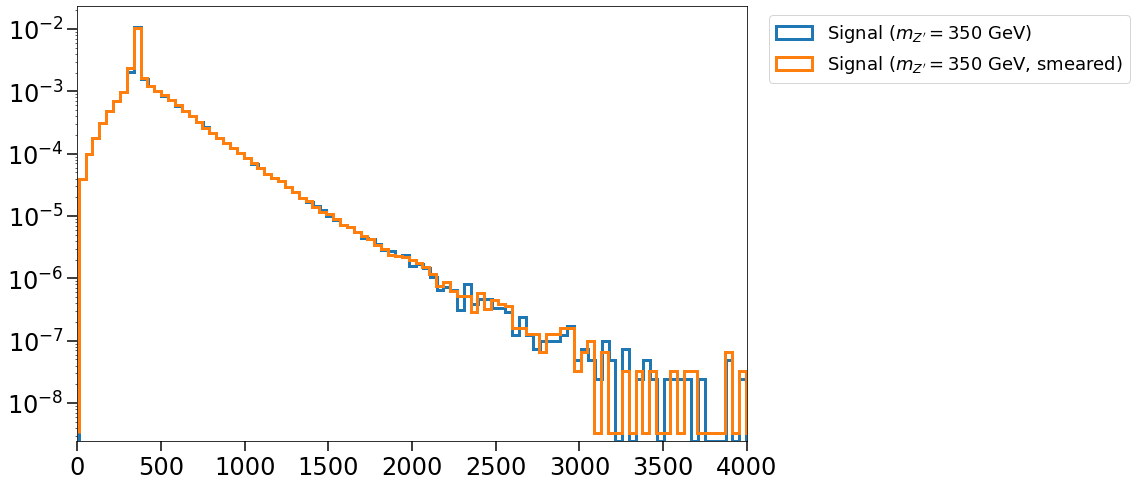

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M b1 b2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(sig_smeared_data[0][:,names.index('M b1 b2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV, smeared)");
    plt.xlim(0,4000)
#     plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

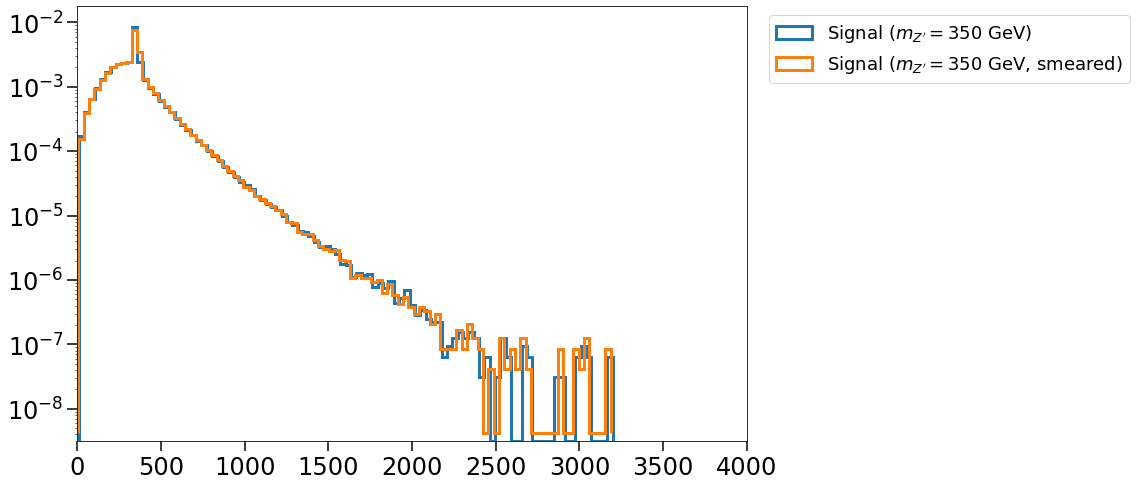

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M b1 b3')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(sig_smeared_data[0][:,names.index('M b1 b3')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV, smeared)");
    plt.xlim(0,4000)
#     plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

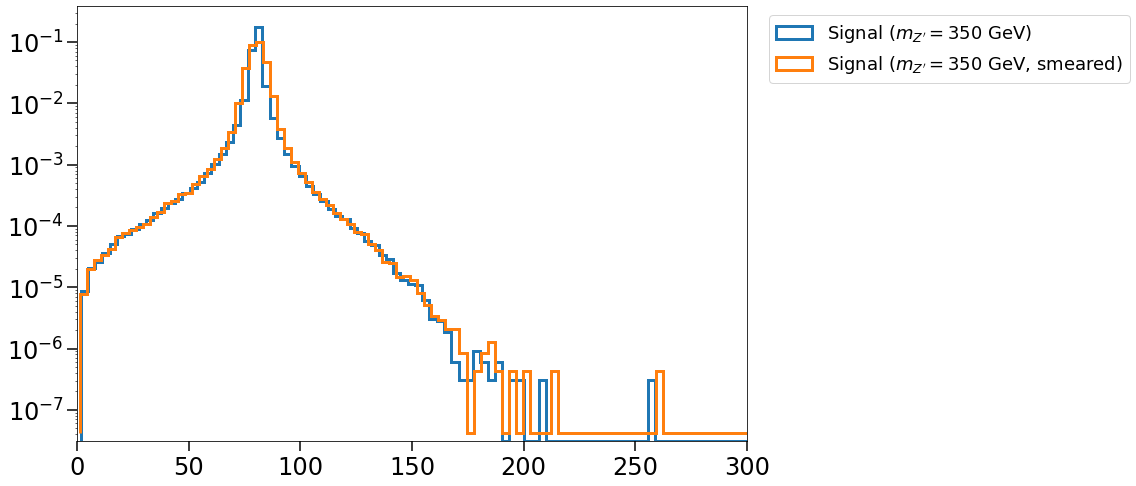

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M j1 j2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(sig_smeared_data[0][:,names.index('M j1 j2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV, smeared)");
    plt.xlim(0,300)
#     plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

## Comparison with Manuel Optimization of Event Selection Criteria

The machine learning approach to optimizing signal significance in a phenomenological problem can be motivated through a comparison with the performance of a more manual approach. The `manual_opt` file contains functions which enable analyses of event selection criteria optimization, which we explore as follows and ultimately compare with our machine learning-based results.

In [ ]:
sigss = signal_data
bgss = background_data
names = get47Dfeatures()

First, let's see what signal significance looks like without making any cuts at all.

In [ ]:
for mass, signal_yield in zip(masses, signal_yields):
    print(
        f"For Z' mass = {mass}, we have a default signal significance of",
        f"{round(manual_significance(signal_yield, background_yields, 1, [1]*3), 4)}")

For Z' mass = 350, we have a default signal significance of 7.2484
For Z' mass = 500, we have a default signal significance of 2.7579
For Z' mass = 1000, we have a default signal significance of 0.2856
For Z' mass = 2000, we have a default signal significance of 0.0148
For Z' mass = 4000, we have a default signal significance of 0.0003


Now we'll ramp up our methodology and use the `opt_sig` function, which takes in data (signal and background), features, and a list of cuts and iteratively scans for cut combinations that maximize signal significance.

In [ ]:
time_before = getTime(form='m')
cuts = [[names.index('M b1 b2'), True, np.linspace(0,400,5)],
        [names.index('M b1 b3'), True, np.linspace(0,400,5)],
        [names.index('M j1 j2'), False, np.append(np.linspace(100,400,4), 10000)],
        [names.index('pT b1'), True, np.linspace(0,500,5)]]
point, sig = opt_sig(sigss[0], bgss, signal_yields[0], background_yields, cuts)
print(f"Cutting at {point} gives maximum significance of {sig} (Z' mass = {masses[0]} GeV)")
time_after = getTime(form='m')
print(f"Runtime: {round(time_after - time_before,3)} minutes")

Cutting at (325.0, 225.0, 150.0, 187.5) gives maximum significance of 20.965001032944777 (Z' mass = 350 GeV)
Runtime: 5.75 minutes


In [ ]:
time_before = getTime(form='m')
cuts = [[names.index('M b1 b2'), True, np.linspace(200,600,5)],
        [names.index('M b1 b3'), True, np.linspace(0,400,5)],
        [names.index('M j1 j2'), False, np.append(np.linspace(100,400,4), 10000)],
        [names.index('pT b1'), True, np.linspace(0,500,5)]]
point, sig = opt_sig(sigss[1], bgss, signal_yields[1], background_yields, cuts)
print(f"Cutting at {point} gives maximum significance of {sig} (Z' mass = {masses[1]} GeV)")
time_after = getTime(form='m')
print(f"Runtime: {round(time_after - time_before,3)} minutes")

Cutting at (475.0, 250.0, 150.0, 250.0) gives maximum significance of 13.882260799836876 (Z' mass = 500 GeV)
Runtime: 5.783 minutes


In [ ]:
time_before = getTime(form='m')
cuts = [[names.index('M b1 b2'), True, np.linspace(600,1200,5)],
        [names.index('M b1 b3'), True, np.linspace(0,400,5)],
        [names.index('M j1 j2'), False, np.append(np.linspace(100,400,4), 10000)],
        [names.index('pT b1'), True, np.linspace(200,600,5)]]
point, sig = opt_sig(sigss[2], bgss, signal_yields[2], background_yields, cuts)
print(f"Cutting at {point} gives maximum significance of {sig} (Z' mass = {masses[2]} GeV)")
time_after = getTime(form='m')
print(f"Runtime: {round(time_after - time_before,3)} minutes")

Cutting at (975.0, 300.0, 150.0, 450.0) gives maximum significance of 6.847931300231083 (Z' mass = 1000 GeV)
Runtime: 8.317 minutes


In [ ]:
time_before = getTime(form='m')
cuts = [[names.index('M b1 b2'), True, np.linspace(1200,2200,5)],
        [names.index('M b1 b3'), True, np.linspace(200,600,5)],
        [names.index('M j1 j2'), False, np.append(np.linspace(100,400,4), 10000)],
        [names.index('pT b1'), True, np.linspace(600,1000,5)]]
point, sig = opt_sig(sigss[3], bgss, signal_yields[3], background_yields, cuts)
print(f"Cutting at {point} gives maximum significance of {sig} (Z' mass = {masses[3]} GeV)")
time_after = getTime(form='m')
print(f"Runtime: {round(time_after - time_before,3)} minutes")

Cutting at (1825.0, 375.0, 150.0, 800.0) gives maximum significance of 3.4044571732873736 (Z' mass = 2000 GeV)
Runtime: 6.1 minutes


In [ ]:
time_before = getTime(form='m')
cuts = [[names.index('M b1 b2'), True, np.linspace(2000,4000,5)],
        [names.index('M b1 b3'), True, np.linspace(0,50,5)],
        [names.index('M j1 j2'), False, np.append(np.linspace(100,500,4), 10000)],
        [names.index('pT b1'), True, np.linspace(0,300,5)]]
point, sig = opt_sig(sigss[4], bgss, signal_yields[4], background_yields, cuts)
print(f"Cutting at {point} gives maximum significance of {sig} (Z' mass = {masses[4]} GeV)")
time_after = getTime(form='m')
print(f"Runtime: {round(time_after - time_before,3)} minutes")

Cutting at (3500.0, 0.0, 266.6666666666667, 93.75) gives maximum significance of 1.0127201854783396 (Z' mass = 4000 GeV)
Runtime: 5.883 minutes


Having found significances manually, let's compile our results, interpolate, and compare with the performance of our machine learning models.

In [ ]:
manual_default_sigs = [
    7.248418610012742, 2.757897361779127, 0.2855952155740879, 0.014759138609928545, 0.000260774522132171]
manual_opt_sigs = [
    20.965001032944777, 13.882260799836876, 6.847931300231083, 3.4044571732873736, 1.0127201854783396]

In [ ]:
manual_default_sigs_f = scipy.interpolate.interp1d(masses, np.log10(manual_default_sigs), kind='cubic')
manual_opt_sigs_f = scipy.interpolate.interp1d(masses, np.log10(manual_opt_sigs), kind='cubic')

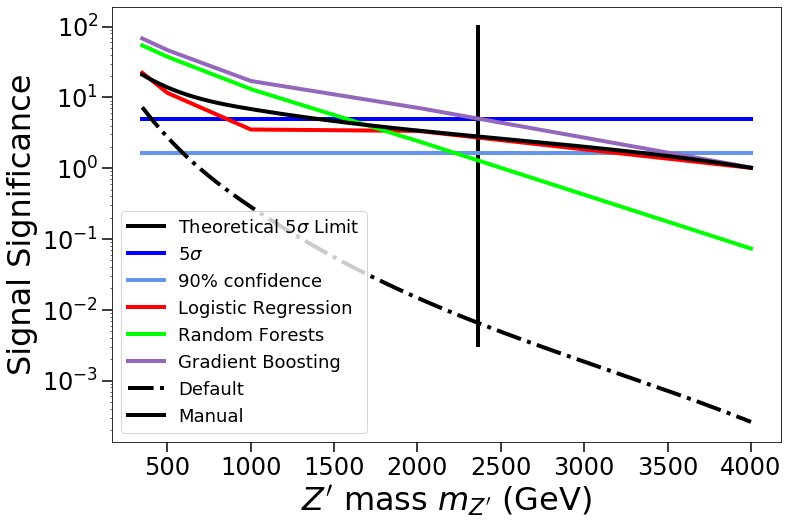

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2.5, 2, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**logreg_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Logistic Regression', 
        c='red')
    plt.plot(
        sample_masses, [10**randforest_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Random Forests', 
        c='lime')
    plt.plot(
        sample_masses, [10**xgradboost_opt_sigs_sepbg_f(m) for m in sample_masses], 
        label='Gradient Boosting', 
        c='tab:purple')
    plt.plot(
        sample_masses, [10**manual_default_sigs_f(m) for m in sample_masses], 
        label='Default', 
        c='black', linestyle='-.')
    plt.plot(
        sample_masses, [10**manual_opt_sigs_f(m) for m in sample_masses], 
        label='Manual', 
        c='black')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass $m_{Z'}$ (GeV)");
    plt.yscale('log')
    plt.legend()

## Kinematic Histograms

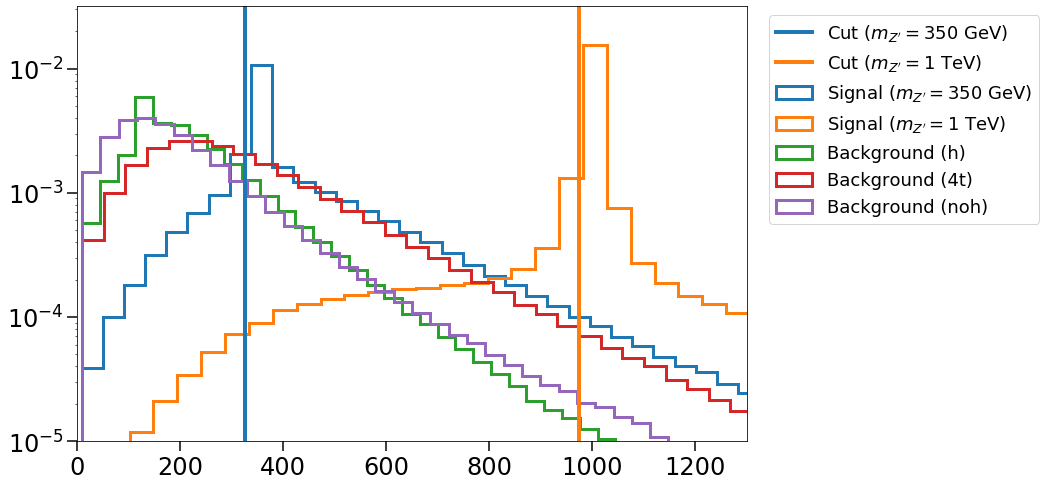

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M b1 b2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(signal_data[2][:,names.index('M b1 b2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 1$ TeV)");
    for bg_data, name in zip(background_data, filename_bgs):
        plt.hist(bg_data[:,names.index('M b1 b2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=f"Background ({name})");
    plt.plot([325]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 350$ GeV)", c='tab:blue')
    plt.plot([975]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 1$ TeV)", c='tab:orange')
    plt.xlim(0,1300)
    plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

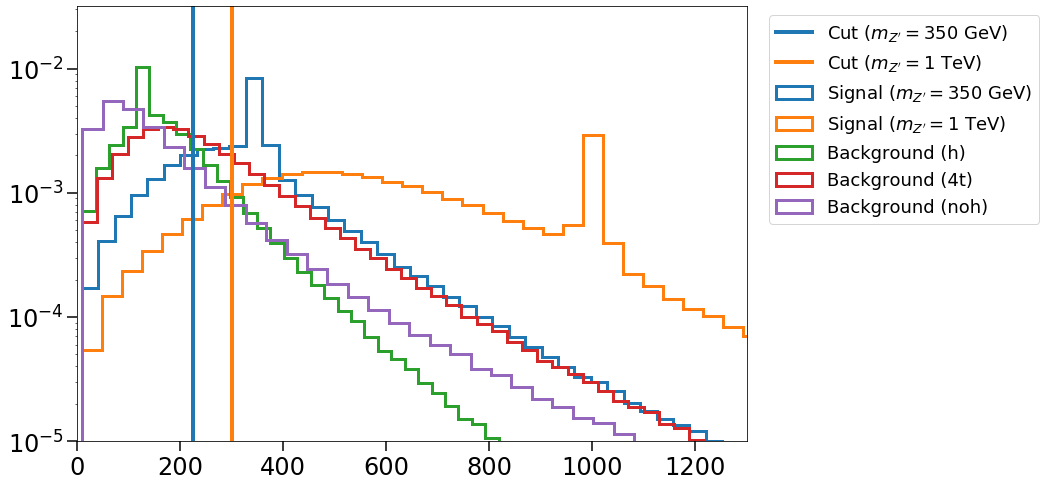

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M b1 b3')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(signal_data[2][:,names.index('M b1 b3')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 1$ TeV)");
    for bg_data, name in zip(background_data, filename_bgs):
        plt.hist(bg_data[:,names.index('M b1 b3')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=f"Background ({name})");
    plt.plot([225]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 350$ GeV)", c='tab:blue')
    plt.plot([300]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 1$ TeV)", c='tab:orange')
    plt.xlim(0,1300)
    plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

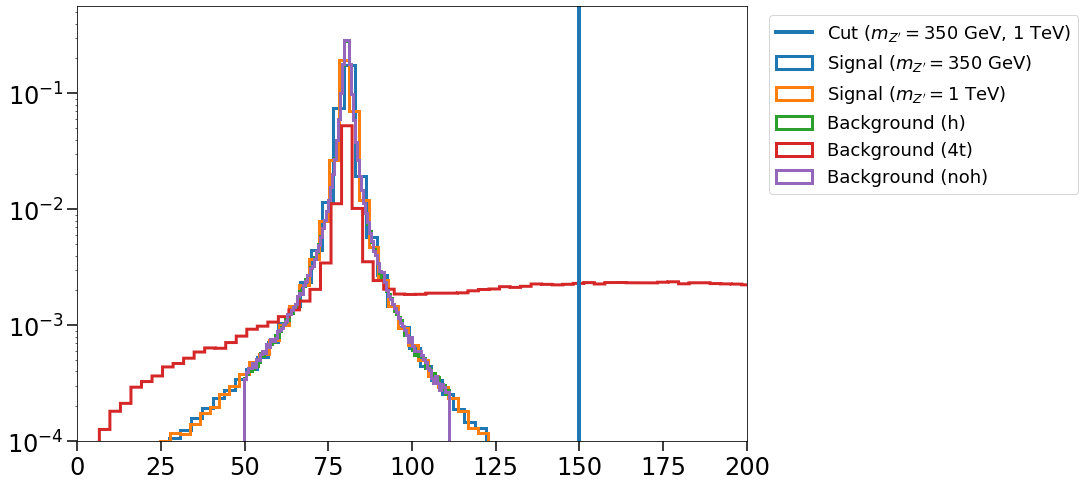

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('M j1 j2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(signal_data[2][:,names.index('M j1 j2')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 1$ TeV)");
    for bg_data, name in zip(background_data, filename_bgs):
        bins = 100 if name is not '4t' else 1000
        plt.hist(bg_data[:,names.index('M j1 j2')], density=True, bins=bins, histtype='step', log=True, linewidth=3, label=f"Background ({name})");
    plt.plot([150]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 350$ GeV, $1$ TeV)", c='tab:blue')
    plt.xlim(0,200)
    plt.ylim(10**-4,10**-0.25)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

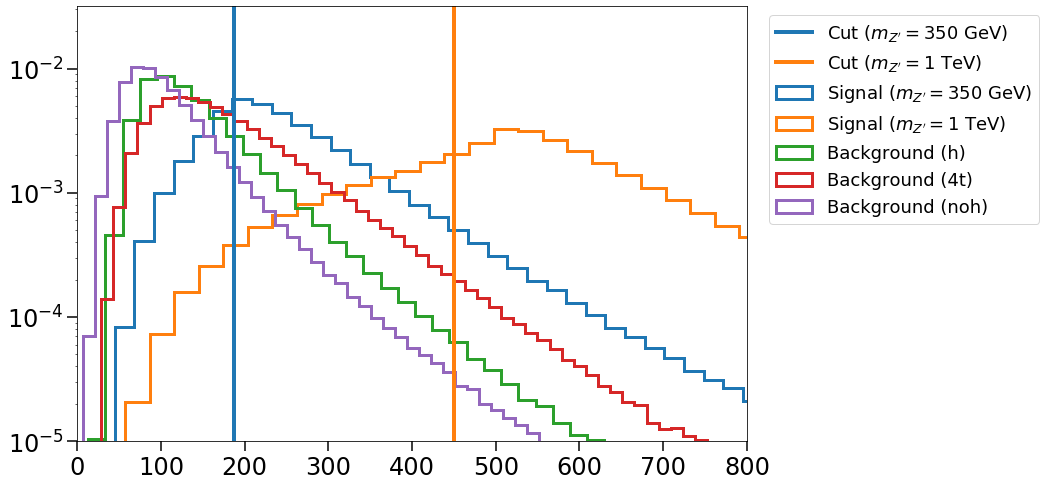

In [ ]:
with plt.rc_context(get_settings()):
    plt.hist(signal_data[0][:,names.index('pT b1')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 350$ GeV)");
    plt.hist(signal_data[2][:,names.index('pT b1')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=r"Signal ($m_{Z'} = 1$ TeV)");
    for bg_data, name in zip(background_data, filename_bgs):
        plt.hist(bg_data[:,names.index('pT b1')], density=True, bins=100, histtype='step', log=True, linewidth=3, label=f"Background ({name})");
    plt.plot([187]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 350$ GeV)", c='tab:blue')
    plt.plot([450]*2, [10**-5, 10**3], label=r"Cut ($m_{Z'} = 1$ TeV)", c='tab:orange')
    plt.xlim(0,800)
    plt.ylim(10**-5,10**-1.5)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")

## Refreshing Models

In [ ]:
logreg_m350G_model = refresh_model(logreg_m350G_model)
logreg_m500G_model = refresh_model(logreg_m500G_model)
logreg_m1T_model = refresh_model(logreg_m1T_model)
logreg_m2T_model = refresh_model(logreg_m2T_model)
logreg_m4T_model = refresh_model(logreg_m4T_model)

In [ ]:
randforest_m350G_model = refresh_model(randforest_m350G_model)
randforest_m500G_model = refresh_model(randforest_m500G_model)
randforest_m1T_model = refresh_model(randforest_m1T_model)
randforest_m2T_model = refresh_model(randforest_m2T_model)
randforest_m4T_model = refresh_model(randforest_m4T_model)

In [ ]:
xgradboost_m350G_model = refresh_model(xgradboost_m350G_model)
xgradboost_m500G_model = refresh_model(xgradboost_m500G_model)
xgradboost_m1T_model = refresh_model(xgradboost_m1T_model)
xgradboost_m2T_model = refresh_model(xgradboost_m2T_model)
xgradboost_m4T_model = refresh_model(xgradboost_m4T_model)

In [ ]:
del signal_data, background_data